# Supervised Learning for HR Separations
## September 1, 2015
<hr>

### 1. Go back to the 'raw' data so I can do the transformation in a pipe-oriented way from the start
* start with histret, histcurr, empl and bene
* actually load from employees_after2001_raw.csv?
* raw_after2001_training.ssv or raw_after2001_eval.ssv?
#### define the source repo
* '/home/kesj/lib/repo/'

### 2. Define the correct working directories
* '/data/discovery/hrsepara/core/' for HDFS
* '/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/' for HDFS and LFS on phd


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')


In [3]:
os.chdir(repodir)
import bear.bear as br

In [4]:
os.chdir(stgdir1local)

In [5]:
from sklearn import cross_validation

In [6]:
hist_record_dtype_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                          'SHIFT':np.str,'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'BOX1':np.str,
                          'BOX2':np.str,'BOX3':np.str,'BOX4':np.str,'BOX5':np.str,'BOX6':np.str,'BOX7':np.str,
                          'BOX8':np.str,'BOX9':np.str,'BOX10':np.str,'RATE1':np.str,'RATE2':np.str,'RATE3':np.str,
                          'RATE4':np.str,'RATE5':np.str,'RATE6':np.str,'RATE7':np.str,'RATE8':np.str,'RATE9':np.str,
                          'RATE10':np.str}

In [7]:
# August 28, 2015
# Begin here by reading in the file
em2002 = pd.read_csv('employees_after2001_raw.csv')
em2002.shape

/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (42,47,92,165,178) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(134267, 183)

In [8]:
em2002.iloc[:10,[42,47,92,165,178]]

,EEO1CODE,EMPL_CLASS,LOCATION,SHIFT,VOLINVOL
0,2,4,99906,N,VOLUNTARY
1,2,4,15921,N,VOLUNTARY
2,2,4,01921,N,VOLUNTARY
3,5,4,17929,N,VOLUNTARY
4,1,4,00915,N,VOLUNTARY
5,6,4,16921,N,VOLUNTARY
6,2,4,05921,N,VOLUNTARY
7,3,4,15105,N,VOLUNTARY
8,1,4,00915,N,VOLUNTARY
9,1,4,99922,N,VOLUNTARY


# create a few additional target columns
* retired
* separated
* invol_sep


In [9]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = em2002.ACTRES1.unique()
print len(uniq_action_reasons_1)
temp_list = [str(x).split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)
act_reason_1_set = set(act_reason_1_list)
print len(act_reason_1_set)

17459
97164
166


In [10]:
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)
possible_retire_codes.sort()

In [11]:
def identify_retired(x,ret_codes =possible_retire_codes):
    try:
        matched = [a for a in x.split(';') if a in ret_codes]
        if len(matched):
            return 1
        else:
            return 0
    except AttributeError:
        return 0

In [12]:
em2002['retired'] = em2002.ACTRES1.apply(lambda x: identify_retired(x))

In [13]:
## create a column for former (i.e. separated but NOT retired)
em2002['former']= 0
my_rows = em2002[(em2002.status==1) & (em2002.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(em2002),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
#em2002.iloc[my_rows,'former']=1
em2002.loc[my_rows,'former']=1#.ix[my_rows]=1
print sum(em2002.former)

Out of 134267 rows, 49674 are separated and not retired.
49674


In [14]:
em2002.columns

Index([u'ACTRES1', u'ACTRES10', u'ACTRES2', u'ACTRES3', u'ACTRES4', u'ACTRES5',
       u'ACTRES6', u'ACTRES7', u'ACTRES8', u'ACTRES9',
       ...
       u'TERMINATION_DT', u'TOTAL_RPT_CNT', u'TOT_MO_SERVICE_SFI', u'VOLINVOL',
       u'DEPENDENT_CNT', u'HAVE_INS', u'HAVE_DEP', u'status', u'retired',
       u'former'],
      dtype='object', length=185)

In [16]:
pd.crosstab(em2002.status, em2002.retired)

retired,0,1
status,,
0,69475,1
1,49674,15117


In [17]:
len(em2002)

134267

####  There is one case where the person is 'retired' but has status of 0 is wrong -- I'm removing this row.

In [15]:
print len(em2002[~((em2002.status == 0)& (em2002.retired == 1))])
em2002 = em2002[~((em2002.status == 0)& (em2002.retired == 1))]
print len(em2002)

134266
134266


## CREATE a Test-train split from this dataset


In [16]:
list_of_indices = list(range(em2002.KEY.nunique()))
print len(list_of_indices )
random.seed(823321)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
em2002.index = list_of_indices # note that random.shuffle does this shuffling inplace
em2002.sort_index(inplace=True)
em2002.head()

134266


,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,TERMINATION_DT,TOTAL_RPT_CNT,TOT_MO_SERVICE_SFI,VOLINVOL,DEPENDENT_CNT,HAVE_INS,HAVE_DEP,status,retired,former
0,MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT;LOCA...,NaN,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,01JAN2015,9,16,NaN,9,Y,Y,0,0,0
1,MERIT;WINDOW 3 - EARLY RET INCENTIVE,MERIT;RRTR W/O JOB NUMBER CHANGE,MERIT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS ...,MERIT;TRANSFER W/O JOB NUMBER CHANGE;MISCELLAN...,MERIT;TRANSFER W/O JOB NUMBER CHANGE;JOB RECLA...,TRANSFER W/O JOB NUMBER CHANGE;MERIT;RATING SC...,COMPANY WIDE CONVERSION;REGIONAL CONVERSION;ME...,RRTR W/JOB NUMBER CHANGE;MERIT;COST OF LIVING ...,TRANSFER W/ JOB NUMBER CHANGE;COST OF LIVING A...,PROMOTION WITH MERIT INCREASE;TRANSFER W/O JOB...,...,31MAR2005,9,188,INVOLUNTARY,1,Y,Y,1,1,0
2,PROMOTION;INCENTIVE;MERIT;TRANSFER W/O JOB NUM...,NaN,SALARY ADJUSTMENT;PROMOTION WITH MERIT INCREAS...,MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,MISCELLANEOUS DATA CHANGE;EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,...,01JAN2015,36,53,NaN,0,Y,N,0,0,0
3,LOCATION/FLOOR CHANGE;MISCELLANEOUS DATA CHANG...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,01JAN2015,7,5,NaN,NaN,NaN,NaN,0,0,0
4,MERIT;REGULAR RETIREMENT,COMPANY WIDE CONVERSION;REGIONAL CONVERSION;CO...,MERIT,MERIT;TRANSFER W/O JOB NUMBER CHANGE,MERIT,MERIT;MARRIAGE;TRANSFER W/O JOB NUMBER CHANGE;...,LOCATION/FLOOR CHANGE;MERIT;TRANSFER W/O JOB N...,MERIT;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFI...,TRANSFER W/O JOB NUMBER CHANGE;MERIT;MISCELLAN...,REVIEW DATE CHANGE;MERIT;TRANSFER W/O JOB NUMB...,...,31MAY2009,8,474,VOLUNTARY,NaN,NaN,NaN,1,1,0


In [42]:
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(em2002))
eval_fraction = 0.20
em2, em2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction,random_state=83221)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2))

Starting with subset of 134266 employees.
Evaluation set has 26854 employees; training set has 107412 employees.


In [43]:
print "For retirement:"
print "training set:\t",
print em2.retired.value_counts()/len(em2)
print "evaluation set:\t",
print em2eval.retired.value_counts()/len(em2eval)
print "For Separation"
print "training set:\t",
print em2.former.value_counts()/len(em2)
print "evaluation set:\t",
print em2eval.former.value_counts()/len(em2eval)


For retirement:
training set:	0    0.887675
1    0.112325
Name: retired, dtype: float64
evaluation set:	0    0.886348
1    0.113652
Name: retired, dtype: float64
For Separation
training set:	0    0.629883
1    0.370117
Name: former, dtype: float64
evaluation set:	0    0.630632
1    0.369368
Name: former, dtype: float64


In [ ]:
# dump these evaluation and training sets
em2.to_csv('raw_after2001_training.ssv',sep=';',index=False)
em2eval.to_csv('raw_after2001_eval.ssv',sep=';',index=False)

In [20]:
em2eval= pd.read_csv('raw_after2001_eval.ssv',sep=';')
em2= pd.read_csv('raw_after2001_training.ssv',sep=';')

/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
## combine these into em2002
len(em2eval),len(em2)

(26854, 107412)

In [44]:
max(em2eval.index), max(em2.index)

(134252, 134265)

## what are the columns included?
* examine building a model/models with minimal_input_col_list:
    - minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','SEX', 'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
* calculate Age_years & Tenure_years for each --> FeatureUnion


In [10]:
em2.columns

Index([u'ACTRES1', u'ACTRES10', u'ACTRES2', u'ACTRES3', u'ACTRES4', u'ACTRES5',
       u'ACTRES6', u'ACTRES7', u'ACTRES8', u'ACTRES9', 
       ...
       u'TERMINATION_DT', u'TOTAL_RPT_CNT', u'TOT_MO_SERVICE_SFI', u'VOLINVOL',
       u'DEPENDENT_CNT', u'HAVE_INS', u'HAVE_DEP', u'status', u'retired',
       u'former'],
      dtype='object', length=185)

In [12]:
minimal_cols_to_keep = ['KEY','HIRE_DT','BIRTHDATE','TERMINATION_DT','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP','former','retired']

In [15]:
len(minimal_cols_to_keep)

13

### Calculate Age_years and Tenure_years for em2 and em2eval (do this separately because I've already split the dataframe)
* first convert dates to timestamps

In [17]:
def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years


In [21]:
##  calculate Age_years and Tenure_years
em2[['hire_tstmp','birth_tstmp','term_tstmp']] = em2[['HIRE_DT','BIRTHDATE','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.strptime(x,'%d%b%Y')))
em2eval[['hire_tstmp','birth_tstmp','term_tstmp']] = em2eval[['HIRE_DT','BIRTHDATE','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.strptime(x,'%d%b%Y')))

In [22]:
em2['Age_years']=em2[['birth_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)
em2['Tenure_years']=em2[['hire_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)
em2eval['Age_years']=em2eval[['birth_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)
em2eval['Tenure_years']=em2eval[['hire_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)

In [23]:
em2002 = pd.concat([em2,em2eval],axis=0)
print em2002.shape
em2002.head()

(134266, 190)


,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,HAVE_INS,HAVE_DEP,status,retired,former,hire_tstmp,birth_tstmp,term_tstmp,Age_years,Tenure_years
0,TRANSFER W/O JOB NUMBER CHANGE;MISCELLANEOUS D...,NaN,EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,N,0,0,0,2013-07-22,1988-01-03,2015-01-01,26.995209,1.445585
1,MERIT;INCENTIVE;MOVED,NaN,MERIT;INCENTIVE;MISCELLANEOUS DATA CHANGE;JOB ...,BENEFITS TRANSACTION;MERIT,MISCELLANEOUS DATA CHANGE;MERIT;JOB CODE CHANG...,REHIRE;SALARY ADJUSTMENT,EMPLOYEE NEW HIRE;RETURN TO SCHOOL,NaN,NaN,NaN,...,NaN,NaN,1,0,1,2006-05-22,1971-10-07,2011-09-16,39.942505,5.319644
2,EMPLOYEE NEW HIRE;MISCELLANEOUS DATA CHANGE;MI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0,1,2014-06-09,1989-08-31,2014-11-21,25.223819,0.451745
3,TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JO...,MISCELLANEOUS DATA CHANGE;TRANSFER W/O JOB NUM...,TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JO...,SALARY PLAN CHANGE;TRANSFER W/O JOB NUMBER CHA...,ORGANIZATIONAL CHANGES;INCENTIVE;MERIT,INCENTIVE;MERIT,MERIT,MERIT,TRANSFER W/O JOB NUMBER CHANGE;MERIT;SP/DEP GA...,PROMOTION;MERIT;MISCELLANEOUS DATA CHANGE,...,Y,N,0,0,0,1984-08-06,1962-10-15,2015-01-01,52.213552,30.403833
4,TRANSFER W/ JOB NUMBER CHANGE;MERIT;INCENTIVE;...,MERIT;TRANSFER W/ JOB NUMBER CHANGE;MISCELLANE...,MERIT;INCENTIVE,MERIT;INCENTIVE,MERIT;INCENTIVE,MISCELLANEOUS DATA CHANGE;MERIT;TRANSFER W/O J...,MERIT,MERIT;MISCELLANEOUS DATA CHANGE,MERIT,TRANSFER W/O JOB NUMBER CHANGE;MERIT;MISCELLAN...,...,Y,Y,1,0,1,1998-08-03,1971-05-05,2013-06-26,42.143737,14.896646


In [24]:
# Reset the index to be unique
em2002.index = np.arange(0,len(em2002))
em2002.index.is_unique

True

In [ ]:
#minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','SEX',
                          #'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
br.get_initial_analysis(em2[minimal_cols_to_keep])

## clean this up more and create set of columns  to use

In [23]:
all_cols =em2002.columns.tolist()
columns_to_omit = [a for a in em2002.columns if a.startswith('ACTRES')]
columns_to_omit.append('ADDRESS1')
columns_to_omit.append('ADDRESS2')
columns_to_omit.append('MAR_STATUS_DT')
columns_to_omit.append('KEY')
columns_to_omit.append('SKEY')
columns_to_omit.append('STATE') # these values are noisier than LOC_STATE
columns_to_omit.append('LOC_CITY')
columns_to_omit.append('zip5')
columns_to_omit.append('PER_ORG')
columns_to_omit.append('POSTAL_SFI')
columns_to_omit.append('VOLINVOL')
columns_to_omit.append('MAR_STA_SNAME_SFI')
print len(columns_to_omit)
print len(all_cols)

22
185


In [ ]:
em2002['Age_years']=em2002[['birth_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)
em2002['Tenure_years']=em2002[['hire_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)

## jump here to import processed/reduced files from Oct. 6, 2015

In [25]:
stgdir2local = '/home/kesj/work/hrsepara/proc'
os.chdir(stgdir2local)

In [26]:
%ls

after2001_v1.csv  after2001_v2.csv  h2o/  tmp/  trans_eval.csv  trans_train.csv


In [27]:
em2 = pd.read_csv('after2001_v2.csv',dtype={'EMPL_CLASS':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SHIFT':np.str})


In [28]:
em2.head()

,EEO1CODE,term_tstmp,birth_tstmp,retired,FLSA_STATUS,LOC_STATE,DEPENDENT_CNT,SUPVCNT1,LEGACY_DEPT_SFI,JOB_FAMILY,...,EXTFUNC_CNT,MAX_RT_ANNUAL,LOCCNT1,status,REMOTE_SUPV,DEPTCNT1,BOX1,Tenure_years,Age_years,hire_age
0,2,2015-01-01,1923-08-12,1,Z,NaN,NaN,0,50669455002,NaN,...,1696,999999,0,1,0,0,0,40.580424,91.389459,50.810078
1,2,2015-01-01,1925-05-02,1,Z,OR,NaN,0,51565692192,NaN,...,56,999999,0,1,0,0,0,38.488706,89.667351,51.179696
2,2,2015-01-01,1925-05-06,1,Z,IL,NaN,0,50165692108,NaN,...,56,999999,0,1,0,0,0,40.657084,89.656400,49.000322
3,5,2015-01-01,1916-10-21,1,N,NJ,NaN,0,217692929,NaN,...,503,0,0,1,0,0,0,50.891170,98.195756,47.305557
4,1,2015-01-01,1925-05-03,1,Z,IL,NaN,0,100850803,NaN,...,83,999999,0,1,0,0,0,65.125257,89.664613,24.539861


In [52]:
##  calculate Age_years and Tenure_years
em2[['hire_tstmp','birth_tstmp','term_tstmp']] = em2[['HIRE_DT','BIRTHDATE','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.strptime(x,'%d%b%Y')))
em2['Age_years']=em2[['birth_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)
em2['Tenure_years']=em2[['hire_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)

/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/pandas/core/frame.py:2265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [53]:
hire_age_tdelta = em2['hire_tstmp']-em2['birth_tstmp']
# convert to days, months, or years
em2['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [25]:
all_cols = em2.columns.tolist()
tstmp_cols = [x for x in em2.columns if x.endswith('tstmp')]
print len(tstmp_cols), tstmp_cols

useful_time_cols = []
useful_time_cols.append('Tenure_years')
useful_time_cols.append('Age_years')
useful_time_cols.append('hire_age')
print len(useful_time_cols), useful_time_cols

3 ['hire_tstmp', 'birth_tstmp', 'term_tstmp']
3 ['Tenure_years', 'Age_years', 'hire_age']


In [26]:
all_cols3 = em2.columns.tolist()
print len(all_cols3)

all_cols3.remove('LOCATION')
all_cols3.remove('LEGACY_DEPT_SFI')
all_cols3.remove('TOT_MO_SERVICE_SFI')
print len(all_cols3)

190
187


## define some  types of columns

In [27]:
my_label_encode_cols = ['JOB_FAMILY', 'GRADE', 'JOB_FUNCTION',
 'FLOR_SFI', 'FUNC_ID_SFI', 'EXT_FUNC_ID_SFI',
 'JOBCODE', 'LOC_TYPE_DESCR_SFI',
 'LOC_STATE']
cat_cols_to_dummy_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME','ETHNIC_GROUP','DIVISION_CODE_SFI','COMPANY']
my_minfix_cols = ['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1']
my_maxfix_cols = ['MAX_RT_ANNUAL']
missing_zero_cols = ['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']
mode_impute_cols = ['MERIT1','PERF1','ADDRCNT1']

#### define the survival encoding method

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
class SurvivalEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix=[],rows_to_scan='all',method='median',max_number_groups=40, my_thresh=0.5):
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.max_num_groups = max_number_groups
        self.thresh = my_thresh
        
    def fit(self,X,y):
        self.survive_columns = {} # dictionary to map old columns to new
        self.survive_values = {}
        self.column_cutoff = {}
        
        
        for col in self.columns_to_fix:
            #(assumes these have previously been label encoded so the values should be ints)"
            ncol=str(col)+"_le"
            num_cutoff = self.max_num_groups
            survive_col = 'surv_'+ncol.lower()
            nuniq = len(X[ncol].unique())
            if nuniq < num_cutoff:
                num_cutoff = nuniq
                
            self.column_cutoff[col]=num_cutoff
            
            #frac_accounted_for = X[col].value_counts().iloc[:num_cutoff].sum()/float(len(X))
            #print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
            # I want to make this fraction close to 80%?
            sf_df = calculate_survival_functions_b(X,y,'Tenure_years', ncol,num_cutoff)
            self.survive_columns[col]=survive_col
            ## create the dictionary
            self.survive_values[col]=return_first_time_survival(sf_df,thresh=self.thresh)
    
        return self
    def transform(self,X,y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            ncol=str(col)+"_le" # assumes labelencoded
            new_col = self.survive_columns[col]
            col_dict = self.survive_values[col]
            X_temp[new_col] = X_temp[ncol].apply(lambda x: col_dict[str(x)])
            original_cols.remove(ncol)
            original_cols.append(new_col)
        
        X_temp = X_temp[original_cols]
        return X_temp

In [29]:
mthl_tenure_range = np.linspace(0,65,781)
def calculate_survival_functions_b(df,y, time_col, col_name,num_cutoff = 40,timerange =mthl_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
        timerange --> min and max range
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=y,label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    #my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    my_grps = grp_value_counts.iloc[:num_cutoff].index.tolist() 
    
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=mthl_tenure_range,event_observed=y.ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        except KeyError: # because of type of the key
            my_sf_date = sfdf[sfdf[int(c)]<=thresh].index[0]

        median_survival_dict[c]=my_sf_date
        
    return median_survival_dict

In [30]:
from sklearn.pipeline import Pipeline, FeatureUnion

In [31]:
pipe2 = Pipeline([("null",br.RemoveAllNull()),
                 #("drop",br.DropColumns(columns_to_drop =my_cols_to_omit)),
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 
                 #("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 ("dummy_encode",br.ConvertCategorical(categorical_columns=cat_cols_to_dummy_encode,method='dummy')),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                 ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",br.FillMissingValue(columns_to_fix=missing_zero_cols,fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=mode_impute_cols,rows_to_scan=0.8))
                 ])

In [32]:
from sklearn import cross_validation

In [33]:
print "Starting with subest of {0} employees.".format(len(em2))
eval_fraction = 0.20
em2build, em2eval = cross_validation.train_test_split(em2,test_size=eval_fraction,random_state=83221)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2build))


Starting with subest of 107412 employees.
Evaluation set has 21483 employees; training set has 85929 employees.


## apply the pipe

In [34]:
y = em2build['former']
build = pipe2.fit_transform(em2build,y)

### now deal with the columns used for modeling here


In [35]:
columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']


In [36]:
em2_tgt_retired = em2.retired
em2_tgt_former = em2.former
eval_tgt_retired = em2eval.retired
eval_tgt_former = em2eval.former

### in an __ad hoc__ way convert these columns based upon our previous 'rules'

In [37]:
other_required_cols = ['hire_tstmp','term_tstmp','birth_tstmp','former','retired']
cols_for_model_prep = []
cols_for_model_prep+=other_required_cols
cols_for_model_prep+=columns_for_modeling


In [38]:
# replace the Y with 1 and N with 0, M with 1 and F with 0
def apply_preprocess_small(df,cols_to_use =[]):
    empl=df[cols_to_use].copy()
    #all_cols = empl.columns.tolist()
    empl['SEX'].replace({'M':1,'F':0},inplace=True)
    empl[['HAVE_INS','HAVE_DEP']]=empl[['HAVE_INS','HAVE_DEP']].replace({'Y':1,'N':0}).copy()
    empl['BOX1']=empl['BOX1'].replace({'H':3,'S':2,'L':1}).copy()
    
    # now deal with ints
    
    # fix the dollar amounts
    min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
    min_min_rt_ann = 17900. # same as above
    min_max_rt_ann = 33155.70

    max_max_rt_ann = 133068.91
    min_merit1 = 0.0
    min_perf1 = 0.0
    fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}
    fix_max_outlier_col_dict = {'MAX_RT_ANNUAL': max_max_rt_ann}

    # replae these values
    for key,value in fix_min_outlier_col_dict.iteritems():
        idx_to_replace = empl[empl[key]<value].index
        empl.loc[idx_to_replace,key]=value
    
    # now fill in missing with zero
    empl.fillna(0,inplace=True)
        
        
    return empl

In [39]:
em2[cols_for_model_prep].head()

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
0,2013-07-22,2015-01-01,1988-01-03,0,0,26.995209,1.445585,37260.00,1260.00,840.00,S,F,Y,N
1,2006-05-22,2011-09-16,1971-10-07,1,0,39.942505,5.319644,65990.15,1928.26,2556.07,S,F,NaN,NaN
2,2014-06-09,2014-11-21,1989-08-31,1,0,25.223819,0.451745,17222.40,NaN,NaN,NaN,F,NaN,NaN
3,1984-08-06,2015-01-01,1962-10-15,0,0,52.213552,30.403833,44429.61,977.67,1194.93,S,F,Y,N
4,1998-08-03,2013-06-26,1971-05-05,1,0,42.143737,14.896646,67212.62,1575.30,3675.69,S,F,Y,Y


### Checking on the validity of the splits

In [40]:
len(em2.index.tolist()) == max(em2.index.tolist())+1 

True

In [41]:
em2mod = apply_preprocess_small(em2,cols_for_model_prep)

In [42]:
br.get_columns_with_nulls(em2[cols_for_model_prep]),br.get_columns_with_nulls(em2mod)

(['MERIT1', 'PERF1', 'BOX1', 'HAVE_INS', 'HAVE_DEP'], [])

In [28]:
em2mod.columns

Index([u'hire_tstmp', u'term_tstmp', u'birth_tstmp', u'former', u'retired',
       u'Age_years', u'Tenure_years', u'SAL1', u'MERIT1', u'PERF1', u'BOX1',
       u'SEX', u'HAVE_INS', u'HAVE_DEP'],
      dtype='object')

In [30]:
columns_for_modeling

['Age_years',
 'Tenure_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP']

# now build the time-kfolds

In [43]:
# define the date range
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)
#full_date_range

14


## so I want to use columns_for_modeling:
['Age_years',
 'Tenure_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP']
for my model building

In [44]:
len(columns_for_modeling)

9

## Utilize temporal kfolds:
1. split the training dataset into windows corresponding to the difference in time
2. 


In [45]:
import itertools
def create_temporal_kfolds(dates_df,date_range,time_delta):
    """
    inputs: date_range
            time_delta (in years)
            dataframe_dates --> assumes 'hire_tstmp' and 'term_tstmp'
    outputs:
            kf is a list of list of list: 
            [indices from original df that are 'in' a fold, indices from original df that are 'out' of a fold]
            each row in this corresponds to the temporal-kfold
            filtered_pairs is a list of start and end times
    """
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no corresponding partner/endtime
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index.tolist()
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index.tolist()
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs

In [47]:
len(em2mod)

107412

In [46]:
kf,fp = create_temporal_kfolds(em2mod,full_date_range,5)
len(kf),len(fp)

13 5 8 107412
9
2002-01-01 2007-01-01 62637 44775
2003-01-01 2008-01-01 60675 46737
2004-01-01 2009-01-01 57408 50004
2005-01-01 2010-01-01 54464 52948
2006-01-01 2011-01-01 53095 54317
2007-01-01 2012-01-01 52902 54510
2008-01-01 2013-01-01 52387 55025
2009-01-01 2014-01-01 52965 54447
2010-01-01 2015-01-01 52276 55136


(9, 9)

In [53]:
len(kf[0])

2

In [54]:
def reset_years2(paired_times,indices,dates_df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    # push these as a data frame so I can merge
    adj_times = pd.DataFrame()
    adj_times['adj_age']=reset_age
    adj_times['adj_tenure']=reset_tenure      
    return adj_times


In [36]:
len(kf[0][0]), len(kf[0][1]), fp[0]

(62637, 44775, ['2002-01-01', '2007-01-01'])

In [55]:
i = 0
start_date = fp[i][0]
end_date = fp[i][1]
in_fold_idx=kf[i][0]
target_col= 'former'
cols_to_copy = ['SEX','Age_years','Tenure_years']
cols_to_copy.append(target_col)
cols_to_copy

['SEX', 'Age_years', 'Tenure_years', 'former']

In [56]:
altered_fold_df = em2mod[cols_to_copy].copy()
        # adjust these
altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
altered_fold_df.fold_mbr = 0
adj_df =reset_years2(fp[i],in_fold_idx,em2mod)
altered_fold_df.head()

,fold_mbr,adj_age,adj_tenure,adj_tgt
0,0,26.995209,1.445585,0
1,0,39.942505,5.319644,1
2,0,25.223819,0.451745,1
3,0,52.213552,30.403833,0
4,0,42.143737,14.896646,1


In [57]:
altered_fold_df.loc[in_fold_idx,['adj_age','adj_tenure']]= adj_df.ix[in_fold_idx]
altered_fold_df.head()

,fold_mbr,adj_age,adj_tenure,adj_tgt
0,0,26.995209,1.445585,0
1,0,39.942505,5.319644,1
2,0,25.223819,0.451745,1
3,0,39.215042,17.404875,0
4,0,30.661821,3.414170,1


In [58]:
def define_target_within_x_years(df,paired_dates,tfold,n_years,target_col):
    """
    inputs:
        df -- data frame
        paired_dates (2nd output from create_temporal_kfolds)
        tfold (1st output from create_temporal_kfolds)
        targe_col --> desired target
        
    plan is to adjust the target, Age and tenure to match time frame of temporal kfold
    outputs:
    """
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        #print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0] # the index of the in_fold_observations 
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['SEX','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
        altered_fold_df.fold_mbr = 0
        
        #ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        adj_df =reset_years2(paired_dates[i],in_fold_idx,df)
        #altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        #altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        altered_fold_df.loc[in_fold_idx,['adj_age','adj_tenure']]=adj_df.ix[in_fold_idx] # assign to the altered values
        new_tgt = (df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        #(em2mod.ix[kf[0][0]]['term_tstmp']<= fp[0][1]).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_tgt']=new_tgt
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [59]:
mypanel5 = define_target_within_x_years(em2mod,fp,kf,5,'former')

9


In [60]:
mypanel5

<class 'pandas.core.panel.Panel'>
Dimensions: 9 (items) x 107412 (major_axis) x 4 (minor_axis)
Items axis: 0 to 8
Major_axis axis: 0 to 107411
Minor_axis axis: fold_mbr to adj_tgt

In [65]:
mypanel5[0].ix[kf[0][1]]

,fold_mbr,adj_age,adj_tenure,adj_tgt
0,0,26.995209,1.445585,0
1,0,39.942505,5.319644,1
2,0,25.223819,0.451745,1
7,0,26.461328,3.266256,0
8,0,31.285421,0.449008,0
10,0,35.118412,0.383299,1
13,0,25.171800,1.790554,0
17,0,25.319644,2.195756,1
22,0,41.527721,7.463381,0
23,0,51.197810,6.893908,0


In [161]:
fp

[['2002-01-01', '2007-01-01'],
 ['2003-01-01', '2008-01-01'],
 ['2004-01-01', '2009-01-01'],
 ['2005-01-01', '2010-01-01'],
 ['2006-01-01', '2011-01-01'],
 ['2007-01-01', '2012-01-01'],
 ['2008-01-01', '2013-01-01'],
 ['2009-01-01', '2014-01-01'],
 ['2010-01-01', '2015-01-01']]

In [69]:
columns_for_modeling

['Age_years',
 'Tenure_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP']

In [75]:
print columns_for_modeling[2:]
X5fold = np.zeros((len(em2mod),len(columns_for_modeling),len(kf)))
y5fold = []
for i in xrange(0,len(kf)):
    X5fold[:,:-2,i]=em2mod[columns_for_modeling[2:]].as_matrix().astype(np.float)
    X5fold[:,-2:,i]=mypanel5[i][['adj_age','adj_tenure']]
    my_y=mypanel5[i][['adj_tgt']].as_matrix().astype(np.int)
    y5fold.append(my_y)

['SAL1', 'MERIT1', 'PERF1', 'BOX1', 'SEX', 'HAVE_INS', 'HAVE_DEP']


In [66]:
default_tstmps = ['birth_tstmp','hire_tstmp','term_tstmp']

In [67]:
def adjust_eval_by_x_years(df,year_val,modeling_columns,tstmp_cols=default_tstmps,target_col='former'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the target to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns))
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)))
    # drop 'Age_years' and Tenure_years from the list
    cols_to_use = []
    cols_to_use+=modeling_columns
    cols_to_use.remove('Age_years')
    cols_to_use.remove('Tenure_years')#.copy()
    """
    Xeval[:,:-2] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    """
    # this version matches the changed ording of columns
    Xeval[:,0]=eval_adj_age.values
    Xeval[:,1]=eval_adj_tenure
    Xeval[:,2:] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    return Xeval, y_eval

In [68]:
evalmod = apply_preprocess_small(em2eval,cols_for_model_prep)

In [69]:
## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

## Reworking this
1. preprocess the test data 
    0. transform all to numbers and fill in missing (```apply_preprocess_small```)
    1. define the time_range
    2. define the time fields (both timestamps and temporally dependent columns)
        1. default_tstmps
        2. _years columns: Age_years & Tenure_years
    3. define the columns to use (for modeling)
2. setup_tfold_models
    * create_temporal_kfolds
    * define_target_within_x_years
    * 
    

In [84]:
panel5[0]

,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,fold_mbr,former
0,26.995209,1.445585,37260.000,1260.00,840.00,2,0,1,0,0,0
1,39.942505,5.319644,65990.150,1928.26,2556.07,2,0,0,0,0,1
2,25.223819,0.451745,17621.760,0.00,0.00,0,0,0,0,0,1
3,39.215042,17.404875,44429.610,977.67,1194.93,2,0,1,0,1,0
4,30.661821,3.414170,67212.620,1575.30,3675.69,2,0,1,1,1,0
5,29.057407,1.382643,31349.040,1018.08,1244.32,2,0,1,0,1,0
6,32.123863,1.650958,86089.460,2798.57,3864.70,2,1,1,1,1,0
7,26.461328,3.266256,39218.800,1580.80,1053.86,2,0,1,0,0,0
8,31.285421,0.449008,26000.000,0.00,0.00,0,1,1,0,0,0
9,53.758804,14.472576,76734.710,909.90,2481.19,2,1,1,0,1,0


In [168]:
contrary_case = []
contrary_case += default_tstmps 
contrary_case.append('jobchg_tstmp')


In [167]:
if [a for a in default_tstmps if a in em2mod.columns] == default_tstmps

True

In [170]:
if not [a for a in contrary_case if a in em2mod.columns] == contrary_case:
    print "some columns in contrary_case are missing."

some columns in contrary_case are missing.


In [77]:
def setup_tfolds(df, n_years, cols_to_model, tgt_value='former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range):
    """ Function to create the temporal kfolds
    parameters:
        df       - a pandas data frame (that has been preprocessed)
        n_years  - size of the temporal window (in years)
        cols_to_model - list of columns to use in the modeling procedure 
        tgt_value  - column name to use as the target variable
        time_cols  - list of columns that are time senitive and must be adjusted
        tstmp_cols - list of columns that contain timestamps for things like hiring, termination and birth
        date_range - list comprising the inclusive annual starting dates from beginning to end of range.
    output:
        tfolds  - a list containing the indices of in and out of fold members for each of the tfolds created
        tfold_panel - a pandas Panel (3D data frame) containing the membership in different folds, the adjusted targets,
            the adjusted timesenitive data, and the columns to use for modeling.
    """    
    # step 1 create the temporal_folds
    if not [a for a in tstmp_cols if a in df.columns] == tstmp_cols:
        print "The list of required timestamp columns do not exist in the input dataframe."
        print tstmp_cols
        exit
    tfolds, paired_dates = create_temporal_kfolds(df[tstmp_cols],date_range, n_years) 
    #defines the time-windows and assigns observations to folds
    
    # create the time-shifted tfolds and push into a pandas Panel (3D data frame)
    tfold_panel=transform_df_to_tfold(df,tfolds,paired_dates,n_years,cols_to_model, tgt_value,tstmp_cols,time_cols)
    return tfold_panel, tfolds
   

In [78]:
def check_if_subset(list1,list2): #compare_column_lists(list1,list2):
    if set(list1).issubset(set(list2)):
        return 1
    else:
        print "{0} is not contained in {1}. Recheck your lists.".format(list1,list2)
        return 0
    

In [79]:
def transform_df_to_tfold(df,tfold,paired_dates,n_years,cols_to_keep,target_col,tstmp_cols,time_cols):
    """
    Function to adjust the input data frame so that time_sensitive columns and target column
    conform to the bounds of that temporal kfold (tfold). Specifically adjust the target, Age and tenure 
    to match time frame of temporal kfold
    
    Parameters:
        df -- a pandas data frame
        paired_dates (2nd output from create_temporal_kfolds)
        tfolds (1st output from create_temporal_kfolds)
        target_col --> desired target
        cols_to_keep --> the list of columns within df that get expressed in df.
        time_cols
        
    plan is to 
    outputs:
        tfold_panel
    """
    #print len(tfold)#, paired_dates
    #print df.columns ,len(df.columns), len(cols_to_keep)
    #return
    # do some sanity checks
    # 1. make sure cols_to_keep, target and tstmp_cols columns are in df.columns
    input_column_list = df.columns.tolist()
    n_total_columns = len(input_column_list)
    #if (n_total_columns != len(cols_to_keep)+len(target_col)+len(tstmp_cols)):
        # now look at each piece
    targetlist = []
    targetlist.append(target_col)
    if not check_if_subset(targetlist,input_column_list):
            #target_col in df.columns:
            #print "{0} target column not present in input set".format(target_col)
        return
    if not check_if_subset(tstmp_cols,input_column_list):
        return
            #[a for a in tstmp_cols if a in input_column_list] == tstmp_cols: # requires
            #print "There are missing timestamp columns. Recheck the list {0}".format(tstmp_cols)
    #        return
    if not check_if_subset(time_cols,input_column_list):
            #[a for a in time_cols if a in input_column_list] == time_cols: # requires
            #print "There are missing timestamp columns. Recheck the list {0}".format(tstmp_cols)
        return    
    if not check_if_subset(cols_to_keep,input_column_list):
        return
    
    ## now set up the columns for manipulation
    cols_to_copy = cols_to_keep
    if not check_if_subset(time_cols,cols_to_keep):
        cols_to_copy+=time_cols
        print len(cols_to_copy)
    
    
    df_dict = {}
    
    # identify which element of tstmp_cols corresponds to term_tstmp
    term_id = tstmp_cols.index('term_tstmp')
    birth_id = tstmp_cols.index('birth_tstmp')
    hire_id = tstmp_cols.index('hire_tstmp')
    #print term_id, tstmp_cols[term_id]
    
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        
        in_fold_idx = tfold[i][0] # the index of the in_fold_observations 
       
        altered_fold_df = df[cols_to_copy].copy()
        altered_fold_df['fold_mbr']=0 # create a new column to identify membership in that fold.
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1 # assign the in_fold_indices to that fold membership
        ####
        # adjust the age and tenure for those in the fold
        reset_age_tdelta = pd.to_datetime(start_date)-df.ix[in_fold_idx][tstmp_cols[birth_id]]
        reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
        reset_tenure_tdelta = pd.to_datetime(start_date)-df.ix[in_fold_idx][tstmp_cols[hire_id]]
        reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
        altered_fold_df.loc[in_fold_idx,'Age_years']=reset_age
        altered_fold_df.loc[in_fold_idx,'Tenure_years']=reset_tenure
        old_tgt = df.ix[tfold[i][1]][target_col]
        new_tgt = (df.ix[in_fold_idx][tstmp_cols[term_id]]<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (df.ix[in_fold_idx][tstmp_cols[term_id]]< end_date).as_matrix().astype(np.int)
            
        altered_fold_df.loc[in_fold_idx,target_col]=new_tgt
        old_tgt = df.ix[tfold[i][1]][target_col]
        altered_fold_df.loc[tfold[i][1],target_col] = old_tgt
        #ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        """adj_df =reset_years2(paired_dates[i],in_fold_idx,df)
        #altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        #altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        altered_fold_df.loc[in_fold_idx,time_cols]=adj_df.ix[in_fold_idx] # assign to the altered values
        
        #(em2mod.ix[kf[0][0]]['term_tstmp']<= fp[0][1]).as_matrix().astype(np.int)
        
        #print "\t", len(new_term),sum(new_term)
        
        """
        
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel
    
    
    

In [307]:
pan1 = transform_df_to_tfold(em2mod,kf,fp,5,columns_for_modeling,'former',default_tstmps,['Age_years','Tenure_years'])
                      
    

In [241]:
pan1.items


Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [243]:
[sum(pan1[a].former.isnull()) for a in xrange(0,len(pan1.items.tolist()))]

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [308]:
pan1[8].head()

,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,fold_mbr,former
0,26.995209,1.445585,37260.00,1260.00,840.00,2,0,1,0,0,0
1,38.237609,3.614037,65990.15,1928.26,2556.07,2,0,0,0,1,1
2,25.223819,0.451745,17621.76,0.00,0.00,0,0,0,0,0,1
3,47.215206,25.405039,44429.61,977.67,1194.93,2,0,1,0,1,0
4,38.661985,11.414334,67212.62,1575.30,3675.69,2,0,1,1,1,1


In [309]:
pan1[0].head()

,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,fold_mbr,former
0,26.995209,1.445585,37260.00,1260.00,840.00,2,0,1,0,0,0
1,39.942505,5.319644,65990.15,1928.26,2556.07,2,0,0,0,0,1
2,25.223819,0.451745,17621.76,0.00,0.00,0,0,0,0,0,1
3,39.215042,17.404875,44429.61,977.67,1194.93,2,0,1,0,1,0
4,30.661821,3.414170,67212.62,1575.30,3675.69,2,0,1,1,1,0


In [216]:
em2mod.head()

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
0,2013-07-22,2015-01-01,1988-01-03,0,0,26.995209,1.445585,37260.00,1260.00,840.00,2,0,1,0
1,2006-05-22,2011-09-16,1971-10-07,1,0,39.942505,5.319644,65990.15,1928.26,2556.07,2,0,0,0
2,2014-06-09,2014-11-21,1989-08-31,1,0,25.223819,0.451745,17621.76,0.00,0.00,0,0,0,0
3,1984-08-06,2015-01-01,1962-10-15,0,0,52.213552,30.403833,44429.61,977.67,1194.93,2,0,1,0
4,1998-08-03,2013-06-26,1971-05-05,1,0,42.143737,14.896646,67212.62,1575.30,3675.69,2,0,1,1


In [210]:
sum(pan1[0].former.isnull()), len(kf[0][1]), len(kf[0][0])

(44775, 44775, 62637)

## Stopped here for LABOR DAY



In [80]:
panel5, tfold5 = setup_tfolds(em2mod, 5, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
   

13 5 8 107412
9
2002-01-01 2007-01-01 62637 44775
2003-01-01 2008-01-01 60675 46737
2004-01-01 2009-01-01 57408 50004
2005-01-01 2010-01-01 54464 52948
2006-01-01 2011-01-01 53095 54317
2007-01-01 2012-01-01 52902 54510
2008-01-01 2013-01-01 52387 55025
2009-01-01 2014-01-01 52965 54447
2010-01-01 2015-01-01 52276 55136


In [252]:
for training, testing in tfold4: #len(tfold4[0][1]), len(tfold4[0][0])
    print len(training),len(testing)

62637 44775
60675 46737
57408 50004
54464 52948
53095 54317
52902 54510
52387 55025
52965 54447
52276 55136
50996 56416


# build a method/function to apply a model to the temporal_kfold

In [ ]:
metrics.mean_squared_error

In [70]:
def apply_tKfold_CV(model, in_panel, tkfolds, cols_to_use, tgt_column = 'former' ):
    """ Calculate the rmse for each cross-validated temporalFold
    
    Parameters:
        model - a scikit learn model
        in_panel  - a pandas Panel with the observed input data adjusted 
        in_y - a pandas Series with the observed outcome
        k - number of cross validation folds (test set will be 1/k of the data)
    """
    RMSE = []
    for fold_id, indices in enumerate(tkfolds):
        training = indices[0]
        testing = indices[1]
        print fold_id, len(training),len(testing)
        X_train, X_test = in_panel[fold_id][cols_to_use].ix[training].as_matrix(), in_panel[fold_id][cols_to_use].ix[testing].as_matrix()
        y_train, y_test = in_panel[fold_id][tgt_column].ix[training].as_matrix(), in_panel[fold_id][tgt_column].ix[testing].as_matrix()
        
        # Train the model
        model.fit(X_train,y_train)
        # use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_fitted)))
    # leave the model fit to the entire dataset
    #model.fit(in_x,in_y)
    
    return RMSE
        

In [71]:
def apply_tKfold_CV2(modeltype, in_panel, tkfolds, cols_to_use, tgt_column = 'former' ):
    """ Calculate the rmse for each cross-validated temporalFold
    
    Parameters:
        model - a scikit learn model name
        in_panel  - a pandas Panel with the observed input data adjusted 
        tgt_column -- the target variable
        cols_to_use -- the input variables to be used in modeling
        tkfolds -- teh temporal timefolds (list of dimension 2)
    outputs:
        models --> the list of fit models
        RMSE --> the rmse error
        
    """
    RMSE = []
    roc_auc = []
    models = []
    
    
    
    for fold_id, indices in enumerate(tkfolds):
        training = indices[0]
        testing = indices[1]
        #print fold_id, len(training),len(testing)
        X_train, X_test = in_panel[fold_id][cols_to_use].ix[training].as_matrix(), in_panel[fold_id][cols_to_use].ix[testing].as_matrix()
        y_train, y_test = in_panel[fold_id][tgt_column].ix[training].as_matrix(), in_panel[fold_id][tgt_column].ix[testing].as_matrix()
        if modeltype == 'rfc':
            model = ensemble.RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True)
        elif modeltype=='bgc':
            model=ensemble.GradientBoostingClassifier(n_estimators=100,max_featrues='auto')
        else:
            model=ensemble.DecisionTreeClassifier()
            
        # Train the model
        model.fit(X_train,y_train)
        # use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_fitted)))
        roc_auc.append(metrics.roc_auc_score(y_test,y_fitted))
        models.append(model)
    # leave the model fit to the entire dataset
    #model.fit(in_x,in_y)
    
    return RMSE,roc_auc,models
        

### Now setup protocol for generating the models

In [285]:
#random_forest = ensemble.RandomForestClassifier(n_estimators=100, max_features='auto')

In [85]:
rmse5,roc_auc5,rfmdl5 = apply_tKfold_CV2('rfc',mypanel5, kf, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)

KeyError: "['Age_years' 'Tenure_years' 'SAL1' 'MERIT1' 'PERF1' 'BOX1' 'SEX' 'HAVE_INS'\n 'HAVE_DEP'] not in index"

In [72]:
rmse4,roc_auc4,rfmdl4 = apply_tKfold_CV2('rfc',panel4, tfold4, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)

NameError: name 'panel4' is not defined

In [336]:
rmse4


[0.53926765485556671,
 0.52658936609588747,
 0.52810764829241508,
 0.53618057821031795,
 0.54265553183845872,
 0.54480081236296662,
 0.54396862298265058,
 0.56607425394265165,
 0.58352676228114586,
 0.60308281099228034]

In [337]:
roc_auc4

[0.70124872855311549,
 0.7211442630869408,
 0.720975889837422,
 0.71262736345318412,
 0.70706672876103971,
 0.7057671720552503,
 0.70501738107573675,
 0.66405599067860499,
 0.63395844190244921,
 0.59750780743867071]

In [315]:
for a in xrange(0,len(panel4)):
    print a, panel4[a][panel4[a].former==1].former.sum()

0 36645.0
1 38582.0
2 39232.0
3 38752.0
4 38053.0
5 37876.0
6 39081.0
7 40562.0
8 42640.0
9 44151.0


## apply to the hold-out (EVAL) set

{'boxes': [<matplotlib.lines.Line2D at 0x7ff306137f10>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff306133e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff30614c190>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff306142b10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff30516bf90>,
  <matplotlib.lines.Line2D at 0x7ff306133810>]}

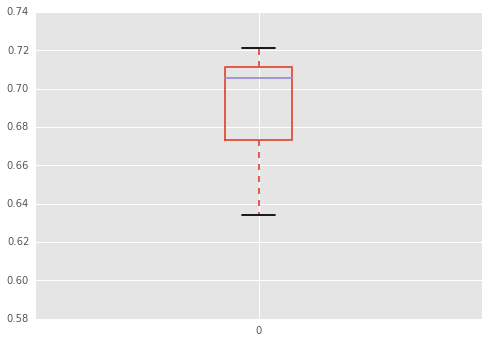

In [339]:
pd.DataFrame(roc_auc4).boxplot()

In [371]:
[(a,rfmdl4[a].oob_score_) for a in xrange(0,len(rfmdl4))]

[(0, 0.89565272921755512),
 (1, 0.89247630819942314),
 (2, 0.89940426421404684),
 (3, 0.9081962397179788),
 (4, 0.91338167435728412),
 (5, 0.91467241314128012),
 (6, 0.91950293011625017),
 (7, 0.906164448220523),
 (8, 0.89901675721172236),
 (9, 0.89675660836144011)]

In [338]:
feature_list= panel4[0].columns
feature_list = columns_for_modeling
feature_list
fi_4df = create_fi_df(rfmdl4,columns_for_modeling)

Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 2=SAL1 (0.217995)
2. feature 0=Age_years (0.182840)
3. feature 4=PERF1 (0.178337)
4. feature 7=HAVE_INS (0.140714)
5. feature 1=Tenure_years (0.126466)
6. feature 3=MERIT1 (0.091327)
7. feature 5=BOX1 (0.032039)
8. feature 8=HAVE_DEP (0.021039)
9. feature 6=SEX (0.009243)
Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 2=SAL1 (0.212425)
2. feature 0=Age_years (0.203631)
3. feature 4=PERF1 (0.153558)
4. feature 7=HAVE_INS (0.142923)
5. feature 1=Tenure_years (0.127797)
6. feature 3=MERIT1 (0.087760)
7. feature 5=BOX1 (0.033448)
8. feature 8=HAVE_DEP (0.028408)
9. feature 6=SEX (0.010050)
Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 2=SAL1 (0.211228)
2. feature 0=Age_years (0.197941)
3. feature 4=PERF1 (0.149745)
4. feature 7=HAVE_INS (0.148954)
5. feature 1=Tenure_years (0.128377)
6. feature 3=MERIT1 (0.093517)
7. feature 5=BOX1 (0.030689)
8. feature 8=HAVE_DEP (0.0293

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [340]:
fi_4df.head()

,fold0_value,fold0_std,fold1_value,fold1_std,fold2_value,fold2_std,fold3_value,fold3_std,fold4_value,fold4_std,...,fold6_value,fold6_std,fold7_value,fold7_std,fold8_value,fold8_std,fold9_value,fold9_std,avg_val,avg_variance
Age_years,0.182840,0.021811,0.203631,0.026375,0.197941,0.024574,0.193265,0.017881,0.192681,0.015337,...,0.201538,0.017176,0.210565,0.017769,0.218341,0.022526,0.226276,0.020633,0.201389,0.013769
BOX1,0.032039,0.024789,0.033448,0.027487,0.030689,0.023695,0.040365,0.029259,0.045179,0.032785,...,0.029433,0.024247,0.045805,0.037788,0.050595,0.042310,0.076114,0.053701,0.042777,0.013830
HAVE_DEP,0.021039,0.032516,0.028408,0.040540,0.029370,0.038912,0.027165,0.034746,0.025958,0.029010,...,0.026638,0.028704,0.017838,0.016214,0.014093,0.009729,0.010591,0.002885,0.022371,0.006405
HAVE_INS,0.140714,0.080872,0.142923,0.070547,0.148954,0.068726,0.162832,0.061108,0.143127,0.054851,...,0.164126,0.043999,0.102431,0.029602,0.052762,0.014944,0.024491,0.007326,0.124368,0.048964
MERIT1,0.091327,0.011990,0.087760,0.013691,0.093517,0.013337,0.102537,0.013272,0.107737,0.013118,...,0.136468,0.045064,0.179592,0.054961,0.216913,0.056458,0.218926,0.062517,0.134549,0.051628


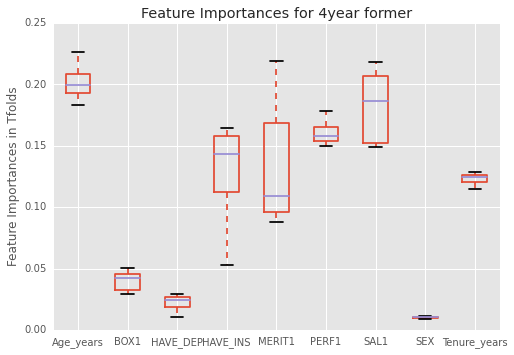

In [347]:
fval_cols = [a for a in fi_4df.columns if 'value' in a]
fi_4df[fval_cols].T.boxplot()
plt.title('Feature Importances for 4year former')
plt.ylabel('Feature Importances in Tfolds')

In [348]:
X4eval, y4eval = adjust_eval_by_x_years(evalmod,4,columns_for_modeling)

There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
3812 5444 17598
new target variable value counts: 
0    17598
1     5444
dtype: int64
_____
23042 23042
input matrix has 9 features


In [404]:
X4evalb, y4evalb = adjust_eval_by_x_years(evalmod,4,columns_for_modeling)

There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
3812 5444 17598
new target variable value counts: 
0    17598
1     5444
dtype: int64
_____
23042 23042
input matrix has 9 features


In [405]:
beval_pred4class, beval_pred4proba = evaluate_models(rfmdl4,X4evalb)

0.78279918903181755

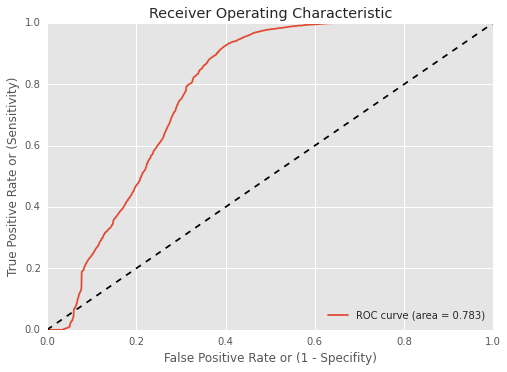

In [406]:
#plot_roc_curve(y4eval,map(eval_pred4class.mean(),np.int))
plot_roc_curve(y4evalb,beval_pred4proba[:,:,:].mean(axis=2))

In [413]:
beval_pred4class.mean(axis=1)

array([ 0.1,  0. ,  0.1, ...,  0. ,  0. ,  0. ])

In [549]:
beval_pred4class.min(axis=1)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

0.357032420819


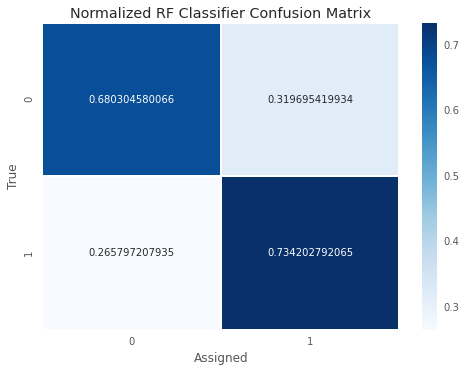

In [416]:
plot_conf_matrix(y4evalb,map(np.int,beval_pred4class.mean(axis=1)+0.7))

0.53104329828743646

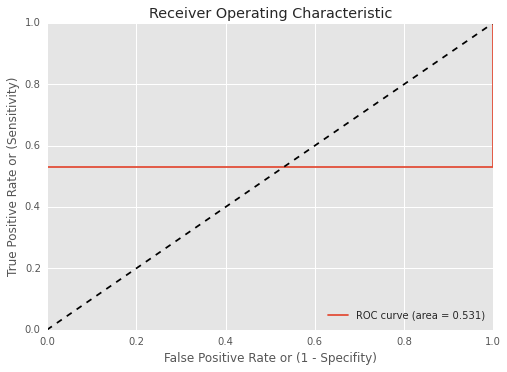

In [354]:
#plot_roc_curve(y4eval,map(eval_pred4class.mean(),np.int))
plot_roc_curve(y4eval,eval_pred4proba[:,:,:].mean(axis=2))

0.229998082207


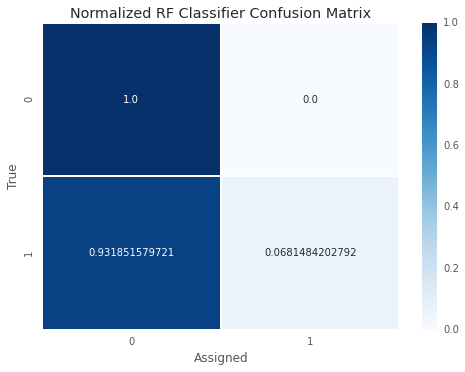

In [355]:
plot_conf_matrix(y4eval,map(np.int,eval_pred4class.mean(axis=1)))

In [392]:
evalmod.head()

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
0,2012-07-16,2015-01-01,1963-03-28,0,0,51.764545,2.461328,27363.06,816.95,668.41,2,0,1,0
1,2013-11-04,2015-01-01,1965-08-05,0,0,49.407255,1.158111,27297.00,297.00,243.00,2,0,1,0
2,1986-07-28,2002-12-03,1962-02-03,1,0,40.829569,16.350445,76987.12,0.00,1983.59,2,0,0,0
3,1981-06-22,2015-01-01,1956-06-08,0,0,58.565366,33.527721,84150.00,0.00,4123.35,2,0,1,1
4,2007-06-11,2010-08-31,1985-09-09,1,0,24.974675,3.222450,45893.45,1336.70,891.14,2,0,0,0


In [388]:
len(y5eval),len(evalmod)

(22884, 26854)

In [399]:
len(evalmod[evalmod.Tenure_years <=5.0+.5])

9969

In [402]:
panel5[0].head()

,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,fold_mbr,former
0,26.995209,1.445585,37260.00,1260.00,840.00,2,0,1,0,0,0
1,39.942505,5.319644,65990.15,1928.26,2556.07,2,0,0,0,0,1
2,25.223819,0.451745,17621.76,0.00,0.00,0,0,0,0,0,1
3,39.215042,17.404875,44429.61,977.67,1194.93,2,0,1,0,1,0
4,30.661821,3.414170,67212.62,1575.30,3675.69,2,0,1,1,1,0


In [401]:
X5eval

array([[  7.69871200e+04,   0.00000000e+00,   1.98359000e+03, ...,
          0.00000000e+00,   3.58295688e+01,   1.13504449e+01],
       [  8.41500000e+04,   0.00000000e+00,   4.12335000e+03, ...,
          1.00000000e+00,   5.35653662e+01,   2.85277207e+01],
       [  4.58934500e+04,   1.33670000e+03,   8.91140000e+02, ...,
          0.00000000e+00,  -2.17526712e+01,   0.00000000e+00],
       ..., 
       [  4.22022600e+04,   1.64266000e+03,   2.00770000e+03, ...,
          1.00000000e+00,   4.66057495e+01,   2.61704312e+01],
       [  5.67012500e+04,   4.10269000e+03,   2.73513000e+03, ...,
          1.00000000e+00,   2.41553730e+01,   2.57837098e+00],
       [  8.42985300e+04,   2.07211000e+03,   2.86148000e+03, ...,
          1.00000000e+00,   4.29041752e+01,   1.87919233e+01]])

In [390]:
evalmod.former.sum()

9972

In [395]:
print y5eval.sum()
y5eval

5999


array([0, 0, 1, ..., 0, 0, 0])

In [417]:
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
3970 5999 16885
new target variable value counts: 
0    16885
1     5999
dtype: int64
_____
22884 22884
input matrix has 9 features


In [420]:
## try for 5year
panel5, tfold5 = setup_tfolds(em2mod, 5, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse5,roc_auc5,rfmdl5 = apply_tKfold_CV2('rfc',panel5, tfold5, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

13 5 8 107412
9
2002-01-01 2007-01-01 62637 44775
2003-01-01 2008-01-01 60675 46737
2004-01-01 2009-01-01 57408 50004
2005-01-01 2010-01-01 54464 52948
2006-01-01 2011-01-01 53095 54317
2007-01-01 2012-01-01 52902 54510
2008-01-01 2013-01-01 52387 55025
2009-01-01 2014-01-01 52965 54447
2010-01-01 2015-01-01 52276 55136
There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
3970 5999 16885
new target variable value counts: 
0    16885
1     5999
dtype: int64
_____
22884 22884
input matrix has 9 features


{'boxes': [<matplotlib.lines.Line2D at 0x7ff2f73ee150>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff306610c90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff306aa6490>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff30b4911d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff3056bbfd0>,
  <matplotlib.lines.Line2D at 0x7ff2f72a98d0>]}

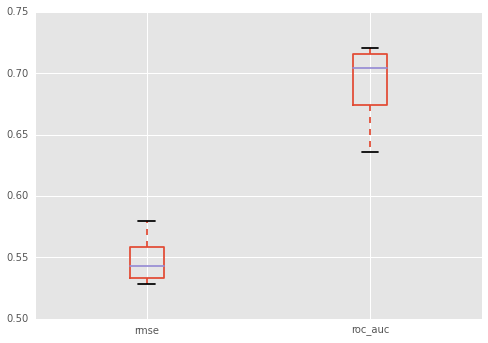

In [421]:
cv_scores5 = pd.DataFrame()
cv_scores5['rmse'] = rmse5#pd.DataFrame(rmse5)#.boxplot()
cv_scores5['roc_auc']=roc_auc5
#pd.DataFrame(roc_auc5).boxplot()
cv_scores5.boxplot()

In [366]:
rmse5

[0.54026070593195352,
 0.52744194571341441,
 0.52643881788265012,
 0.53499927101765621,
 0.54076932894548957,
 0.54554112264098542,
 0.54323312330968043,
 0.56649588664219774,
 0.58447398358929992,
 0.6027888250086455]

In [591]:
ev5df.ix[18]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
Name: 18, dtype: float64

In [552]:
ev5df = pd.DataFrame()
ev5df['avg'] = eval_pred5class.mean(axis=1)
#ev5df.head()
ev5df['min'] = eval_pred5class.min(axis=1)
ev5df['max']= eval_pred5

,avg
0,0.444444
1,0.000000
2,0.111111
3,0.111111
4,1.000000


0.121970973509


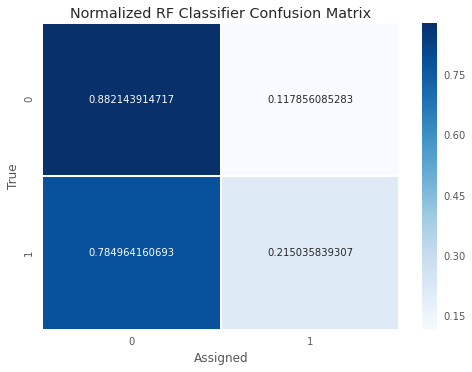

In [422]:
eval_pred5class, eval_pred5proba = evaluate_models(rfmdl5,X5eval)
plot_conf_matrix(y5eval,map(np.int,eval_pred5class.mean(axis=1)))

0.79610454767828986

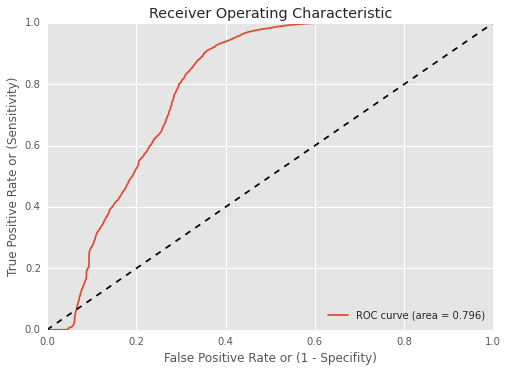

In [423]:
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))

Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 2=SAL1 (0.227789)
2. feature 0=Age_years (0.186488)
3. feature 4=PERF1 (0.170582)
4. feature 7=HAVE_INS (0.126731)
5. feature 1=Tenure_years (0.124263)
6. feature 3=MERIT1 (0.091865)
7. feature 5=BOX1 (0.033876)
8. feature 8=HAVE_DEP (0.028858)
9. feature 6=SEX (0.009548)
Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 2=SAL1 (0.212645)
2. feature 0=Age_years (0.202912)
3. feature 4=PERF1 (0.165371)
4. feature 7=HAVE_INS (0.134072)
5. feature 1=Tenure_years (0.128256)
6. feature 3=MERIT1 (0.088716)
7. feature 5=BOX1 (0.029538)
8. feature 8=HAVE_DEP (0.028379)
9. feature 6=SEX (0.010111)
Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 0=Age_years (0.208382)
2. feature 2=SAL1 (0.202341)
3. feature 4=PERF1 (0.154405)
4. feature 7=HAVE_INS (0.145226)
5. feature 1=Tenure_years (0.121424)
6. feature 3=MERIT1 (0.089555)
7. feature 8=HAVE_DEP (0.036907)
8. feature 5=BOX1 (0.0318

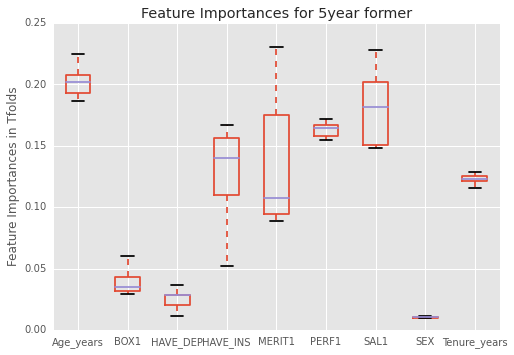

In [367]:
fi_5df = create_fi_df(rfmdl5,columns_for_modeling)
val_cols = [a for a in fi_5df.columns if 'value' in a]
fi_5df[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former')
plt.ylabel('Feature Importances in Tfolds')

## Try loading the previously pickled models

In [378]:
import joblib as jl

In [379]:
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100auto/'

/home/kesj/work/hrsepara/eda/jl_5yr_100auto


In [381]:
stored_mdl = jl.load('frf100.pkl')

In [382]:
Seval_pred5class,Seval_pred5proba = evaluate_models(stored_mdl,X5eval)

0.79612935193078016

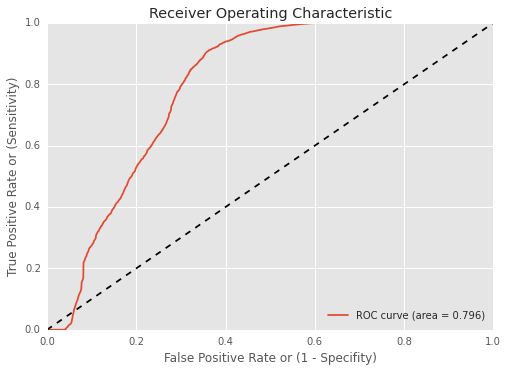

In [383]:
plot_roc_curve(y5eval,Seval_pred5proba[:,:,:].mean(axis=2))

## repeat for 3 years:

In [424]:
panel3, tfold3 = setup_tfolds(em2mod, 3, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse3,roc_auc3,rfmdl3 = apply_tKfold_CV2('rfc',panel3, tfold3, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X3eval, y3eval = adjust_eval_by_x_years(evalmod,3,columns_for_modeling)

13 3 10 107412
11
2002-01-01 2005-01-01 62637 44775
2003-01-01 2006-01-01 60675 46737
2004-01-01 2007-01-01 57408 50004
2005-01-01 2008-01-01 54464 52948
2006-01-01 2009-01-01 53095 54317
2007-01-01 2010-01-01 52902 54510
2008-01-01 2011-01-01 52387 55025
2009-01-01 2012-01-01 52965 54447
2010-01-01 2013-01-01 52276 55136
2011-01-01 2014-01-01 50996 56416
2012-01-01 2015-01-01 50284 57128
There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
3652 4760 18442
new target variable value counts: 
0    18442
1     4760
dtype: int64
_____
23202 23202
input matrix has 9 features


0.0908294033514


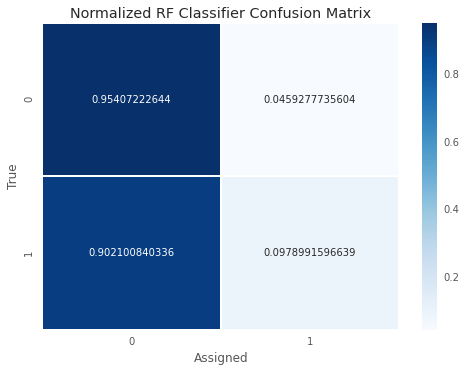

In [425]:
eval_pred3class, eval_pred3proba = evaluate_models(rfmdl3,X3eval)
plot_conf_matrix(y3eval,map(np.int,eval_pred3class.mean(axis=1)))

0.77209502605944225

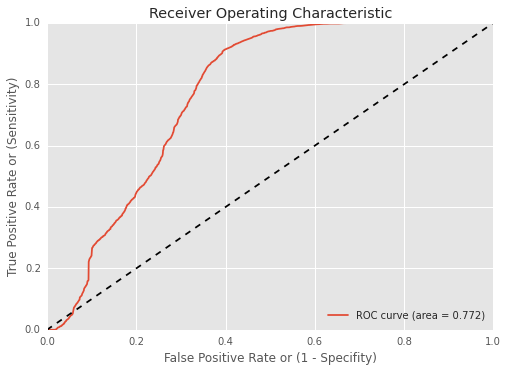

In [426]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))

In [427]:
np.shape(eval_pred3proba)

(23202, 2, 11)

0.77209502605944225

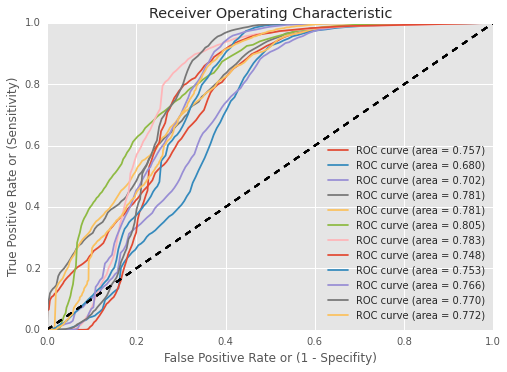

In [430]:
for i in xrange(0,len(panel3)):
    #fpr,tpr,treshholds = roc_
    plot_roc_curve(y3eval,eval_pred3proba[:,:,i])
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))

0.75700701791398706

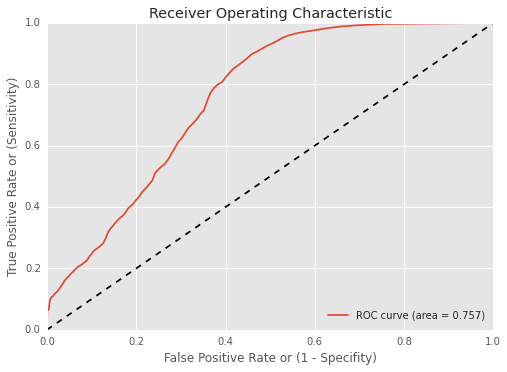

In [428]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,0])

In [431]:
panel2, tfold2 = setup_tfolds(em2mod, 2, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse2,roc_auc2,rfmdl2 = apply_tKfold_CV2('rfc',panel2, tfold2, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X2eval, y2eval = adjust_eval_by_x_years(evalmod,2,columns_for_modeling)

13 2 11 107412
12
2002-01-01 2004-01-01 62637 44775
2003-01-01 2005-01-01 60675 46737
2004-01-01 2006-01-01 57408 50004
2005-01-01 2007-01-01 54464 52948
2006-01-01 2008-01-01 53095 54317
2007-01-01 2009-01-01 52902 54510
2008-01-01 2010-01-01 52387 55025
2009-01-01 2011-01-01 52965 54447
2010-01-01 2012-01-01 52276 55136
2011-01-01 2013-01-01 50996 56416
2012-01-01 2014-01-01 50284 57128
2013-01-01 2015-01-01 52371 55041
There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
2952 3936 19966
new target variable value counts: 
0    19966
1     3936
dtype: int64
_____
23902 23902
input matrix has 9 features


0.0617083265796


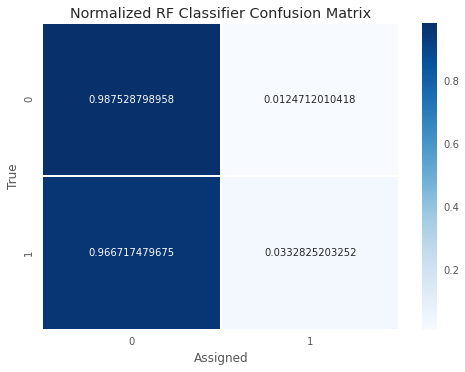

In [432]:
eval_pred2class, eval_pred2proba = evaluate_models(rfmdl2,X2eval)
plot_conf_matrix(y2eval,map(np.int,eval_pred2class.mean(axis=1)))

In [433]:
panel1, tfold1 = setup_tfolds(em2mod, 1, columns_for_modeling, tgt_value = 'former',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
rmse1,roc_auc1,rfmdl1 = apply_tKfold_CV2('rfc',panel1, tfold1, cols_to_use = columns_for_modeling, tgt_column='former')#['columns_for_modeling'],em2mod['former'],)
X1eval, y1eval = adjust_eval_by_x_years(evalmod,1,columns_for_modeling)

13 1 12 107412
13
2002-01-01 2003-01-01 62637 44775
2003-01-01 2004-01-01 60675 46737
2004-01-01 2005-01-01 57408 50004
2005-01-01 2006-01-01 54464 52948
2006-01-01 2007-01-01 53095 54317
2007-01-01 2008-01-01 52902 54510
2008-01-01 2009-01-01 52387 55025
2009-01-01 2010-01-01 52965 54447
2010-01-01 2011-01-01 52276 55136
2011-01-01 2012-01-01 50996 56416
2012-01-01 2013-01-01 50284 57128
2013-01-01 2014-01-01 52371 55041
2014-01-01 2015-01-01 55023 52389
There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
1906 2898 22050
new target variable value counts: 
0    22050
1     2898
dtype: int64
_____
24948 24948
input matrix has 9 features


-0.00229528030486


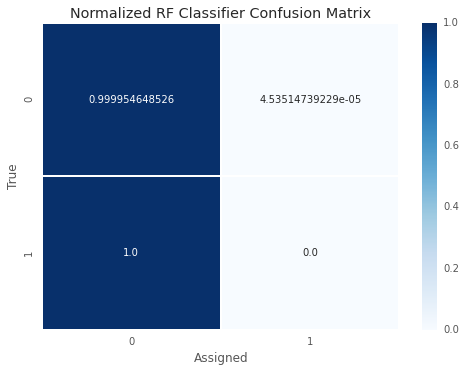

In [434]:
eval_pred1class, eval_pred1proba = evaluate_models(rfmdl1,X1eval)
plot_conf_matrix(y1eval,map(np.int,eval_pred1class.mean(axis=1)))

0.85850413687444149

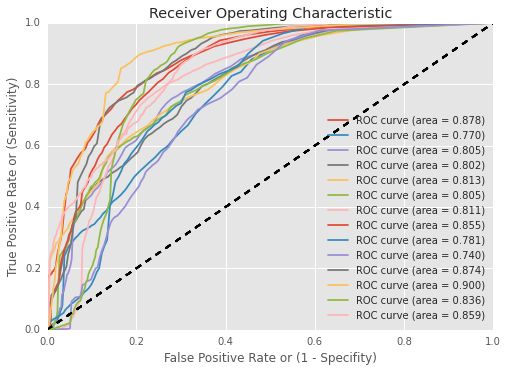

In [435]:
for i in xrange(0,len(panel1)):
    #fpr,tpr,treshholds = roc_
    plot_roc_curve(y1eval,eval_pred1proba[:,:,i])
plot_roc_curve(y1eval,eval_pred1proba[:,:,:].mean(axis=2))

In [437]:
em2mod.columns

Index([u'hire_tstmp', u'term_tstmp', u'birth_tstmp', u'former', u'retired',
       u'Age_years', u'Tenure_years', u'SAL1', u'MERIT1', u'PERF1', u'BOX1',
       u'SEX', u'HAVE_INS', u'HAVE_DEP'],
      dtype='object')

In [438]:
Rpanel2[0].head()

,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,fold_mbr,former
0,26.995209,1.445585,37260.00,1260.00,840.00,2,0,1,0,0,0
1,39.942505,5.319644,65990.15,1928.26,2556.07,2,0,0,0,0,1
2,25.223819,0.451745,17621.76,0.00,0.00,0,0,0,0,0,1
3,39.215042,17.404875,44429.61,977.67,1194.93,2,0,1,0,1,0
4,30.661821,3.414170,67212.62,1575.30,3675.69,2,0,1,1,1,0


## Try for 'retired'

In [469]:
today = pd.to_datetime('2015-01-01')
today

Timestamp('2015-01-01 00:00:00')

In [470]:

evalmod[(evalmod['retired']==1) & (today - evalmod['term_tstmp']<= 1.5)]

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
1781,1976-07-06,2015-01-01,1925-05-02,0,1,89.667351,38.488706,17621.76,0.00,0.00,0,1,0,0
3555,1961-06-06,2015-01-01,1939-08-01,0,1,75.419576,53.571526,44883.39,0.00,0.00,0,1,0,0
7273,1974-05-06,2015-01-01,1925-05-06,0,1,89.656400,40.657084,17621.76,0.00,0.00,0,1,0,0
8511,1972-01-03,2015-01-01,1940-11-29,0,1,74.088980,42.995209,49026.48,1817.54,1944.66,2,0,1,0
12476,1979-03-01,2015-01-01,1945-09-20,0,1,69.281314,35.838467,157000.00,0.00,0.00,3,1,1,1
14483,1949-11-16,2015-01-01,1925-05-03,0,1,89.664613,65.125257,17621.76,0.00,0.00,0,1,0,0
15345,1968-04-08,2015-01-01,1939-10-29,0,1,75.175907,46.732375,56695.17,0.00,0.00,0,1,0,0
16702,1982-01-18,2015-01-01,1941-05-03,0,1,73.664613,32.952772,42242.78,909.34,870.73,2,0,0,0
18634,1977-11-14,2015-01-01,1936-11-04,0,1,78.157426,37.130732,62956.78,0.00,2781.24,0,0,1,0
19758,1957-10-08,2015-01-01,1938-07-06,0,1,76.490075,57.232033,65623.80,0.00,0.00,0,1,0,0


In [472]:
def adjust_eval_by_x_yearsR(df,year_val,modeling_columns,endtime,tstmp_cols=default_tstmps,target_col='retired'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (endtime - df['term_tstmp'] <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the target to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns))
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)))
    # drop 'Age_years' and Tenure_years from the list
    cols_to_use = []
    cols_to_use+=modeling_columns
    cols_to_use.remove('Age_years')
    cols_to_use.remove('Tenure_years')#.copy()
    """
    Xeval[:,:-2] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    """
    # this version matches the changed ording of columns
    Xeval[:,0]=eval_adj_age.values
    Xeval[:,1]=eval_adj_tenure
    Xeval[:,2:] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    return Xeval, y_eval

In [474]:
RX2eval, Ry2eval = adjust_eval_by_x_yearsR(evalmod,2,columns_for_modeling, today,target_col = 'retired')

There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
6886 11 19957
new target variable value counts: 
0    19957
1       11
dtype: int64
_____
19968 19968
input matrix has 9 features


In [443]:
Rpanel2, Rtfold2 = setup_tfolds(em2mod, 2, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse2,Rroc_auc2,Rrfmdl2 = apply_tKfold_CV2('rfc',Rpanel2, Rtfold2, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


13 2 11 107412
12
2002-01-01 2004-01-01 62637 44775
2003-01-01 2005-01-01 60675 46737
2004-01-01 2006-01-01 57408 50004
2005-01-01 2007-01-01 54464 52948
2006-01-01 2008-01-01 53095 54317
2007-01-01 2009-01-01 52902 54510
2008-01-01 2010-01-01 52387 55025
2009-01-01 2011-01-01 52965 54447
2010-01-01 2012-01-01 52276 55136
2011-01-01 2013-01-01 50996 56416
2012-01-01 2014-01-01 50284 57128
2013-01-01 2015-01-01 52371 55041
There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
6886 2 19966
new target variable value counts: 
0    19966
1        2
dtype: int64
_____
19968 19968
input matrix has 9 features


0.65706951764475441

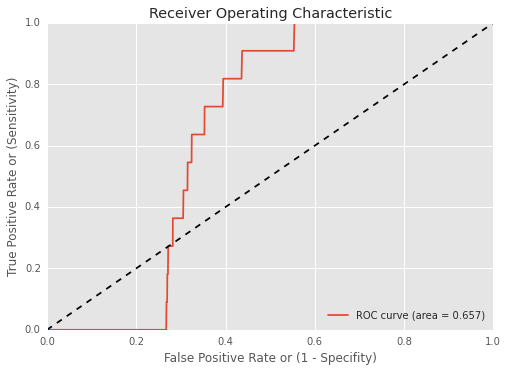

In [475]:
Reval_pred2class,Reval_pred2proba = evaluate_models(Rrfmdl2,RX2eval)
plot_roc_curve(Ry2eval,Reval_pred2proba[:,:,:].mean(axis=2))

In [476]:
Rpanel5, Rtfold5 = setup_tfolds(em2mod, 5, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse5,Rroc_auc5,Rrfmdl5 = apply_tKfold_CV2('rfc',Rpanel5, Rtfold5, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)
RX5eval, Ry5eval = adjust_eval_by_x_yearsR(evalmod,5,columns_for_modeling, today,target_col = 'retired')

13 5 8 107412
9
2002-01-01 2007-01-01 62637 44775
2003-01-01 2008-01-01 60675 46737
2004-01-01 2009-01-01 57408 50004
2005-01-01 2010-01-01 54464 52948
2006-01-01 2011-01-01 53095 54317
2007-01-01 2012-01-01 52902 54510
2008-01-01 2013-01-01 52387 55025
2009-01-01 2014-01-01 52965 54447
2010-01-01 2015-01-01 52276 55136
There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
9926 11 16917
new target variable value counts: 
0    16917
1       11
dtype: int64
_____
16928 16928
input matrix has 9 features


0.6735183005798363

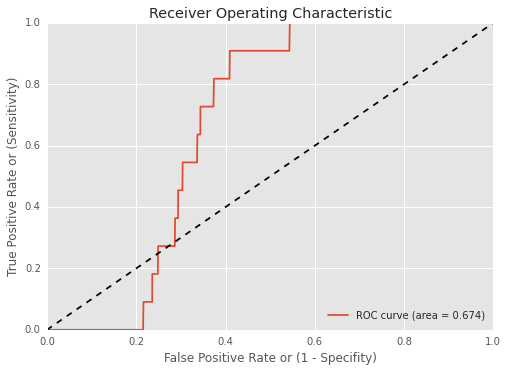

In [477]:
Reval_pred5class,Reval_pred5proba = evaluate_models(Rrfmdl5,RX5eval)
plot_roc_curve(Ry5eval,Reval_pred5proba[:,:,:].mean(axis=2))

In [448]:
Rpanel4, Rtfold4 = setup_tfolds(em2mod,4, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse4,Rroc_auc4,Rrfmdl4 = apply_tKfold_CV2('rfc',Rpanel4, Rtfold5, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


13 4 9 107412
10
2002-01-01 2006-01-01 62637 44775
2003-01-01 2007-01-01 60675 46737
2004-01-01 2008-01-01 57408 50004
2005-01-01 2009-01-01 54464 52948
2006-01-01 2010-01-01 53095 54317
2007-01-01 2011-01-01 52902 54510
2008-01-01 2012-01-01 52387 55025
2009-01-01 2013-01-01 52965 54447
2010-01-01 2014-01-01 52276 55136
2011-01-01 2015-01-01 50996 56416
There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
9251 5 17598
new target variable value counts: 
0    17598
1        5
dtype: int64
_____
17603 17603
input matrix has 9 features


There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
9251 11 17592
new target variable value counts: 
0    17592
1       11
dtype: int64
_____
17603 17603
input matrix has 9 features


0.64997519533672321

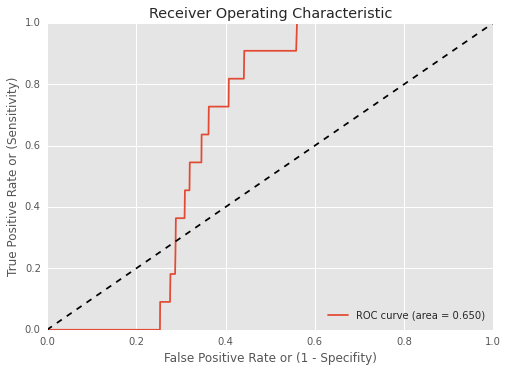

In [478]:
RX4eval, Ry4eval = adjust_eval_by_x_yearsR(evalmod,4,columns_for_modeling, today,target_col = 'retired')
Reval_pred4class,Reval_pred4proba = evaluate_models(Rrfmdl4,RX4eval)
plot_roc_curve(Ry4eval,Reval_pred4proba[:,:,:].mean(axis=2))

In [450]:
Rpanel3, Rtfold3 = setup_tfolds(em2mod, 3, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse3,Rroc_auc3,Rrfmdl3 = apply_tKfold_CV2('rfc',Rpanel3, Rtfold3, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


13 3 10 107412
11
2002-01-01 2005-01-01 62637 44775
2003-01-01 2006-01-01 60675 46737
2004-01-01 2007-01-01 57408 50004
2005-01-01 2008-01-01 54464 52948
2006-01-01 2009-01-01 53095 54317
2007-01-01 2010-01-01 52902 54510
2008-01-01 2011-01-01 52387 55025
2009-01-01 2012-01-01 52965 54447
2010-01-01 2013-01-01 52276 55136
2011-01-01 2014-01-01 50996 56416
2012-01-01 2015-01-01 50284 57128
There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
8409 3 18442
new target variable value counts: 
0    18442
1        3
dtype: int64
_____
18445 18445
input matrix has 9 features


There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
8409 11 18434
new target variable value counts: 
0    18434
1       11
dtype: int64
_____
18445 18445
input matrix has 9 features


0.65431958732381867

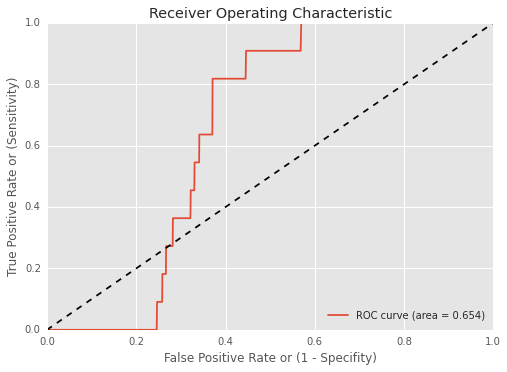

In [480]:
RX3eval, Ry3eval = adjust_eval_by_x_yearsR(evalmod,3,columns_for_modeling,today, target_col = 'retired')
Reval_pred3class,Reval_pred3proba = evaluate_models(Rrfmdl3,RX3eval)
plot_roc_curve(Ry3eval,Reval_pred3proba[:,:,:].mean(axis=2))

In [451]:
Rpanel1, Rtfold1 = setup_tfolds(em2mod, 1, columns_for_modeling, tgt_value = 'retired',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = default_tstmps, date_range=full_date_range)
Rrmse1,Rroc_auc1,Rrfmdl1 = apply_tKfold_CV2('rfc',Rpanel5, Rtfold5, cols_to_use = columns_for_modeling, tgt_column='retired')#['columns_for_modeling'],em2mod['former'],)


13 1 12 107412
13
2002-01-01 2003-01-01 62637 44775
2003-01-01 2004-01-01 60675 46737
2004-01-01 2005-01-01 57408 50004
2005-01-01 2006-01-01 54464 52948
2006-01-01 2007-01-01 53095 54317
2007-01-01 2008-01-01 52902 54510
2008-01-01 2009-01-01 52387 55025
2009-01-01 2010-01-01 52965 54447
2010-01-01 2011-01-01 52276 55136
2011-01-01 2012-01-01 50996 56416
2012-01-01 2013-01-01 50284 57128
2013-01-01 2014-01-01 52371 55041
2014-01-01 2015-01-01 55023 52389
There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
4804 0 22050
new target variable value counts: 
0    22050
dtype: int64
_____
22050 22050
input matrix has 9 features


In [463]:
evalmod.head()

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
0,2012-07-16,2015-01-01,1963-03-28,0,0,51.764545,2.461328,27363.06,816.95,668.41,2,0,1,0
1,2013-11-04,2015-01-01,1965-08-05,0,0,49.407255,1.158111,27297.00,297.00,243.00,2,0,1,0
2,1986-07-28,2002-12-03,1962-02-03,1,0,40.829569,16.350445,76987.12,0.00,1983.59,2,0,0,0
3,1981-06-22,2015-01-01,1956-06-08,0,0,58.565366,33.527721,84150.00,0.00,4123.35,2,0,1,1
4,2007-06-11,2010-08-31,1985-09-09,1,0,24.974675,3.222450,45893.45,1336.70,891.14,2,0,0,0


In [460]:
RX1eval[:10]

array([[  5.07645448e+01,   1.46132786e+00,   2.73630600e+04,
          8.16950000e+02,   6.68410000e+02,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  3.98295688e+01,   1.53504449e+01,   7.69871200e+04,
          0.00000000e+00,   1.98359000e+03,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.75653662e+01,   3.25277207e+01,   8.41500000e+04,
          0.00000000e+00,   4.12335000e+03,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  2.39746749e+01,   2.22245038e+00,   4.58934500e+04,
          1.33670000e+03,   8.91140000e+02,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.20896646e+01,   6.37234771e-01,   2.88528200e+04,
          9.65250000e+02,   7.89750000e+02,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  3.66700890e+01,   6.37234771e-01,   2.68580000e+04,
   

In [490]:
len(evalmod[(evalmod['retired']==1) & (today - evalmod['term_tstmp'] <= 5.5*365.25)])

11

In [488]:
5.5*365.25

2008.875

In [492]:
sum((today - evalmod['term_tstmp']) <= 5.5*365.25)

13959

There are 26854 elements in the evaluation set
original target variable value counts: 0    23920
1     2934
dtype: int64
4804 11 22039
new target variable value counts: 
0    22039
1       11
dtype: int64
_____
22050 22050
input matrix has 9 features


0.5117580817476457

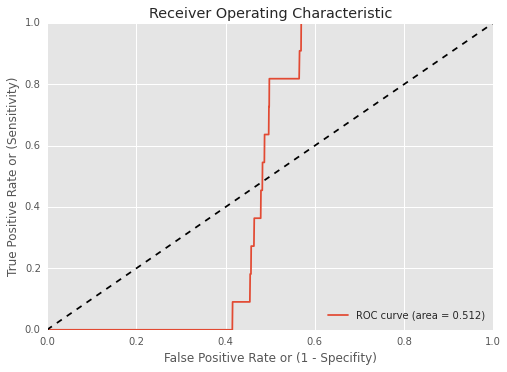

In [481]:
RX1eval, Ry1eval = adjust_eval_by_x_yearsR(evalmod,1,columns_for_modeling, today, target_col = 'retired')
Reval_pred1class,Reval_pred1proba = evaluate_models(Rrfmdl1,RX1eval)
plot_roc_curve(Ry1eval,Reval_pred1proba[:,:,:].mean(axis=2))

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
0,2013-07-22,2015-01-01,1988-01-03,0,0,26.995209,1.445585,37260.00,1260.00,840.00,2,0,1,0
1,2006-05-22,2011-09-16,1971-10-07,1,0,39.942505,5.319644,65990.15,1928.26,2556.07,2,0,0,0
2,2014-06-09,2014-11-21,1989-08-31,1,0,25.223819,0.451745,17621.76,0.00,0.00,0,0,0,0
3,1984-08-06,2015-01-01,1962-10-15,0,0,52.213552,30.403833,44429.61,977.67,1194.93,2,0,1,0
4,1998-08-03,2013-06-26,1971-05-05,1,0,42.143737,14.896646,67212.62,1575.30,3675.69,2,0,1,1


## Save the models

In [500]:
%cd ../

/home/kesj/work/hrsepara


In [501]:
!mkdir save_models_1

In [502]:
%cd 'save_models_1/'

/home/kesj/work/hrsepara/save_models_1


In [503]:
!mkdir sep
!mkdir ret

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=True, random_state=None, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=True, random_state=None, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=Tr

In [513]:
## define the base directories
case_dir = ['sep/','ret/']
## define the model cases
nyrs = map(str,np.arange(1,6))
base='rfmdl'
model_listing = []
pkl_file_dict = {}
#dump_file_listing= []
for case in case_dir:
    #!cd {case_dir}
    for yr in nyrs:
        #dir_name = case+yr+'/'
        #!mkdir {yr}
        #!cd {yr}
        model_name = base+yr
        file_name = 'rf'
        if case == 'ret/':
            model_name = 'R'+model_name
            file_name = 'R'+file_name
        file_name+=yr
        file_name+='.pkl'
        
        print dir_name, model_name, file_name
        model_listing.append(model_name)
        pkl_file_dict[model_name]=file_name
        #file_list = jl.dump(model_name,file_name)
        #dump_file_listing.append(file_list)
        #!cd ../
    #!cd ../

ret/5/ rfmdl1 rf1.pkl
ret/5/ rfmdl2 rf2.pkl
ret/5/ rfmdl3 rf3.pkl
ret/5/ rfmdl4 rf4.pkl
ret/5/ rfmdl5 rf5.pkl
ret/5/ Rrfmdl1 Rrf1.pkl
ret/5/ Rrfmdl2 Rrf2.pkl
ret/5/ Rrfmdl3 Rrf3.pkl
ret/5/ Rrfmdl4 Rrf4.pkl
ret/5/ Rrfmdl5 Rrf5.pkl


In [527]:
store_dir = '/home/kesj/work/hrsepara/save_models_1/'
dump_file_listing = []
for mdl in model_listing:
    if mdl.startswith('R'):
        base_dir = store_dir + 'ret'
        #!cd {base_dir}#/home/kesj/work/hrsepara/save_models_1/ret        
    else:
        base_dir = store_dir + 'sep'
    
    os.chdir(base_dir)#!cd {base_dir}
    yr = mdl[-1]
    #os.makedirs(yr)#!mkdir {yr}
    #os.chdir(yr)#!cd {yr}
    print yr,mdl
    #file_list =jl.dump(mdl,pkl_file_dict[mdl])
    #dump_file_listing.append(file_list)

1 rfmdl1
2 rfmdl2
3 rfmdl3
4 rfmdl4
5 rfmdl5
1 Rrfmdl1
2 Rrfmdl2
3 Rrfmdl3
4 Rrfmdl4
5 Rrfmdl5


In [530]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')

In [532]:
os.mkdir('1')
os.chdir('1')

In [533]:
dump_file_listing = []

In [534]:
flist = jl.dump(rfmdl1,'rf1.pkl')
dump_file_listing.append(flist)

In [536]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('2')
os.chdir('2')
flist = jl.dump(rfmdl2,'rf2.pkl')
dump_file_listing.append(flist)

In [537]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('3')
os.chdir('3')
flist = jl.dump(rfmdl3,'rf3.pkl')
dump_file_listing.append(flist)

In [538]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('4')
os.chdir('4')
flist = jl.dump(rfmdl4,'rf4.pkl')
dump_file_listing.append(flist)


In [539]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/sep')
os.mkdir('5')
os.chdir('5')
flist = jl.dump(rfmdl5,'rf5.pkl')
dump_file_listing.append(flist)

In [541]:
k=5
for yr in nyrs:
    os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
    os.mkdir(yr)
    os.chdir(yr)
    flist = jl.dump(,'rf5.pkl')
dump_file_listing.append(flist)

1
2
3
4
5


In [544]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')

In [546]:
os.mkdir('1')
os.chdir('1')
flist = jl.dump(Rrfmdl1,'Rrf1.pkl')
dump_file_listing.append(flist)

os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('2')
os.chdir('2')
flist = jl.dump(Rrfmdl2,'Rrf2.pkl')
dump_file_listing.append(flist)

In [547]:
os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('3')
os.chdir('3')
flist = jl.dump(Rrfmdl3,'Rrf3.pkl')
dump_file_listing.append(flist)

os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('4')
os.chdir('4')
flist = jl.dump(Rrfmdl4,'Rrf4.pkl')
dump_file_listing.append(flist)

os.chdir('/home/kesj/work/hrsepara/save_models_1/ret')
os.mkdir('5')
os.chdir('5')
flist = jl.dump(Rrfmdl5,'Rrf5.pkl')
dump_file_listing.append(flist)

In [548]:
panel4[0]

,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,fold_mbr,former
0,26.995209,1.445585,37260.000,1260.00,840.00,2,0,1,0,0,0
1,39.942505,5.319644,65990.150,1928.26,2556.07,2,0,0,0,0,1
2,25.223819,0.451745,17621.760,0.00,0.00,0,0,0,0,0,1
3,39.215042,17.404875,44429.610,977.67,1194.93,2,0,1,0,1,0
4,30.661821,3.414170,67212.620,1575.30,3675.69,2,0,1,1,1,0
5,29.057407,1.382643,31349.040,1018.08,1244.32,2,0,1,0,1,0
6,32.123863,1.650958,86089.460,2798.57,3864.70,2,1,1,1,1,0
7,26.461328,3.266256,39218.800,1580.80,1053.86,2,0,1,0,0,0
8,31.285421,0.449008,26000.000,0.00,0.00,0,1,1,0,0,0
9,53.758804,14.472576,76734.710,909.90,2481.19,2,1,1,0,1,0


### Aside:
* KFold within sklearn does the following 

In [152]:
std_folds = cross_validation.KFold(n=len(em2mod),n_folds=3)

In [153]:
for std_tr,std_test in std_folds:
    print len(std_tr), len(std_test)

71608 35804
71608 35804
71608 35804


## now build t_fold models


In [77]:
from sklearn import ensemble

In [ ]:
len(tfold5)

In [79]:
%%time
five_rf_mdl_100A = []
for i in xrange(0,len(kf)):
    train_y = y5fold[i].flatten()[kf[i][0]]
    train_X = X5fold[kf[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_estimators=100,max_features='auto',n_jobs=1)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl_100A.append(rfmdl)

CPU times: user 1min 51s, sys: 19 ms, total: 1min 51s
Wall time: 1min 51s


In [80]:
five_rf_mdl_100A[0].feature_importances_

array([ 0.21752539,  0.08433674,  0.1638515 ,  0.03275951,  0.00928675,
        0.15455183,  0.0218742 ,  0.1921542 ,  0.12365989])

In [94]:
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

There are 26854 elements in the evaluation set
original target variable value counts: 0    16882
1     9972
dtype: int64
3970 5999 16885
new target variable value counts: 
0    16885
1     5999
dtype: int64
_____
22884 22884
input matrix has 9 features


In [127]:
eval_pred5class,eval_pred5proba = evaluate_models(five_rf_mdl_100A,X5eval)

In [97]:
from sklearn import metrics

In [98]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

0.220784933588


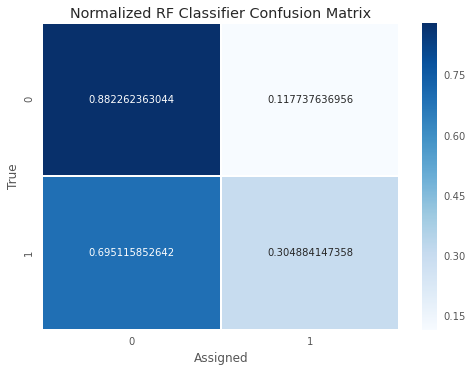

In [128]:
plot_conf_matrix(y5eval,map(np.int,eval_pred5class.mean(axis=1)))

In [100]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

(0, 1.01)

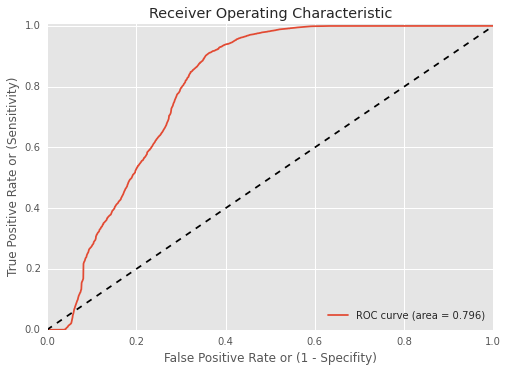

In [129]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

### function to help explore the features

In [102]:
# function to push feature_importances for a set of RF models into a dataframe
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def plotFI(forest,featureNames=[],show_plot=True):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df

In [104]:
feature_list = [a for a in columns_for_modeling if 'years' not in a]
feature_list += columns_for_modeling[:2]
feature_list

['SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP',
 'Age_years',
 'Tenure_years']

In [123]:
#[e for e in tree0.estimators_]
np.shape(tree0.indices_)



(52276,)

In [130]:
fi_5df = create_fi_df(five_rf_mdl_100A,feature_list)
#tree0 = rfmdl[0]

Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 0=SAL1 (0.217525)
2. feature 7=Age_years (0.192154)
3. feature 2=PERF1 (0.163851)
4. feature 5=HAVE_INS (0.154552)
5. feature 8=Tenure_years (0.123660)
6. feature 1=MERIT1 (0.084337)
7. feature 3=BOX1 (0.032760)
8. feature 6=HAVE_DEP (0.021874)
9. feature 4=SEX (0.009287)
Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 0=SAL1 (0.213789)
2. feature 7=Age_years (0.200426)
3. feature 5=HAVE_INS (0.156602)
4. feature 2=PERF1 (0.142122)
5. feature 8=Tenure_years (0.119367)
6. feature 1=MERIT1 (0.086036)
7. feature 3=BOX1 (0.037773)
8. feature 6=HAVE_DEP (0.034709)
9. feature 4=SEX (0.009175)
Number of Features: 9
Number of Trees: 100
Feature ranking:
1. feature 7=Age_years (0.206034)
2. feature 0=SAL1 (0.200190)
3. feature 5=HAVE_INS (0.160416)
4. feature 2=PERF1 (0.142255)
5. feature 8=Tenure_years (0.115751)
6. feature 1=MERIT1 (0.093904)
7. feature 3=BOX1 (0.040531)
8. feature 6=HAVE_DEP (0.0320

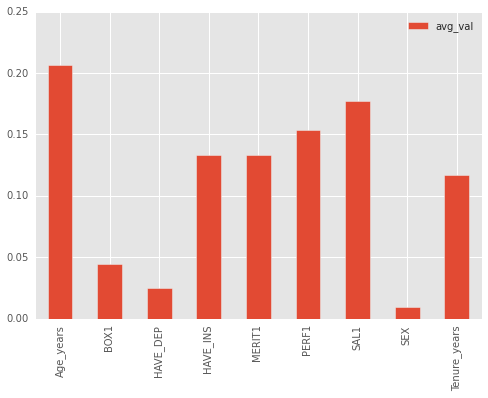

In [135]:
fi_5df.plot(kind='bar',y='avg_val')#,std='avg_var')

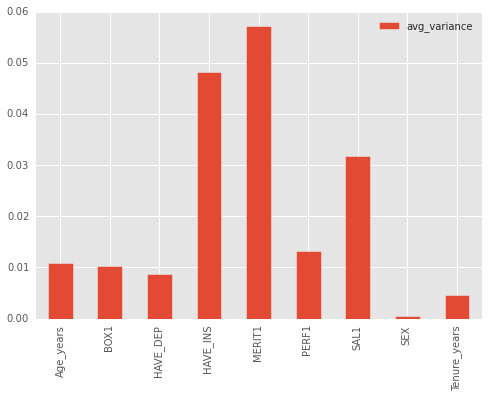

In [144]:
fi_5df.plot(kind='bar',y='avg_variance')

##save this model to disk

In [145]:
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100auto/'

/home/kesj/work/hrsepara/eda/jl_5yr_100auto


In [146]:
import joblib as jl

4510

In [150]:
%cd ../
!du -h 'jl_5yr_100auto'

/home/kesj/work/hrsepara/eda
621M	jl_5yr_100auto


## work through evaluating based upon a set of existing models
* I want to save all the separations to a data frame and then save it to disk
* likewise with the retirements

In [607]:
#os.chdir('../../')

os.chdir(stgdir1local)
%ls

Ajl_5yr_100/                  employee_table_summary.csv
c2_EAS.ssv                    example_0.ssv
cp_SR_EAS.txt                 five_rf_mdljl/
empl1_aaf_1_ci.pkl            five_rf_mdl.pkl
empl_aaf_1_hazards.pkl        fourthousand_rfsc1.RData
empl_aaf_1.pkl                fthou_rf_sepTen.RData
employee_dataframe3.ssv       header_0.ssv
employee_dataframe4.tsv       histret_mod
employee_dataframe5.tsv       jl_3yr_100/
employee_dataframe6.tsv       jl_5yr_100/
employee_dataframe7long.tsv   jl_5yr_100auto/
employee_dataframe8.tsv       raw_after2001_eval.ssv
employee_dataframe9.tsv       raw_after2001_training.ssv
employee_dataframe.ssv        SBR
employee_dataframe.tsv        sbr_mod
employee_df_1.csv             tree0.dot
employee_df_2.csv             tree.dot
employees_after2001_raw.csv   us_unemployment_monthly_seas.csv*
employee_table_summary_3.csv


In [608]:
MODEL_BASE_PATH='../save_models_1/'
pred_cases = ['sep/','ret/']
pred_years = map(np.str,np.arange(1,6))


In [609]:
sep_proba_df = []
ret_proba_df = []
import joblib as jl


In [610]:
def evaluate_models_simple(model_list,X,mode='mean',offset=0):
    """ Function to apply a set of models to a given input and generate the predicted value(s)
    :param model_list --> input list of models
    :param X --> input array to apply models to
    :param mode --> what sort of output to return; default is mean
    intermediates
        eval_pred_class --> array of classification prediction for each model
        eval_pred_proba --> array of predicted probabilities for each model
    """
    import numpy as np
    eval_pred_class = np.zeros((len(X),len(model_list)))
    eval_pred_proba = np.zeros((len(X),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(X)
        eval_pred_class[:,i]=mdl.predict(X)
        eval_pred_proba[:,:,i]=eval_proba
    if mode == 'mean':
        # average the probabilities (for class=1) and return the mean predicted probability
        prediction = np.mean(eval_pred_proba[:,1,:],axis=1)
        #eval_pred_proba[:,1,:].mean(axis=2)

    elif mode == 'class': # return the desired class prediction
        prediction = map(np.int,eval_pred_class.mean(axis=1))
    return prediction

In [617]:
#del X
np.shape(X5eval)
X = X5eval[30:80,:]
np.shape(X)

(50, 9)

In [632]:
sep_proba_df = []
for idx,pyr in enumerate(pred_years):
    pkl_name ='rf'+pyr+'.pkl'#5.pkl'
    path_name =MODEL_BASE_PATH+pred_cases[0]+pyr+'/'
    print path_name, pkl_name
    #path_name = MODEL_BASE_PATH+pred_cases[0]+"5/"#pred_years[0]+'/'
        # load a model, evaluate it and return the 'average' probability for each person
        #abs_mdl_name = os.path.abspath(path_name+pkl_name)
    mdl_name = path_name+pkl_name
    stored_mdl = jl.load(mdl_name)
    stored_prediction = evaluate_models_simple(stored_mdl,X)#stored_pred,stored_pred_proba = evaluate_models(stored_mdl,X)

    df = pd.DataFrame(stored_prediction.T)
    df.columns=['sep'+pyr+'yr']
    #df.#print stored_prediction
    sep_proba_df.append(df)



../save_models_1/sep/1/ rf1.pkl
../save_models_1/sep/2/ rf2.pkl
../save_models_1/sep/3/ rf3.pkl
../save_models_1/sep/4/ rf4.pkl
../save_models_1/sep/5/ rf5.pkl


NameError: name 'spe_proba_df' is not defined

In [633]:
len(sep_proba_df)
#sep_df.shape()

5

In [634]:
sep_df = pd.concat([a for a in sep_proba_df],axis=1)
sep_df.head()

,sep1yr,sep2yr,sep3yr,sep4yr,sep5yr
0,0.011538,0.063333,0.106364,0.144,0.201111
1,0.065385,0.137500,0.195455,0.400,0.501111
2,0.080769,0.141667,0.191818,0.231,0.277778
3,0.120000,0.190000,0.276364,0.320,0.364444
4,0.005385,0.011667,0.013636,0.014,0.008889


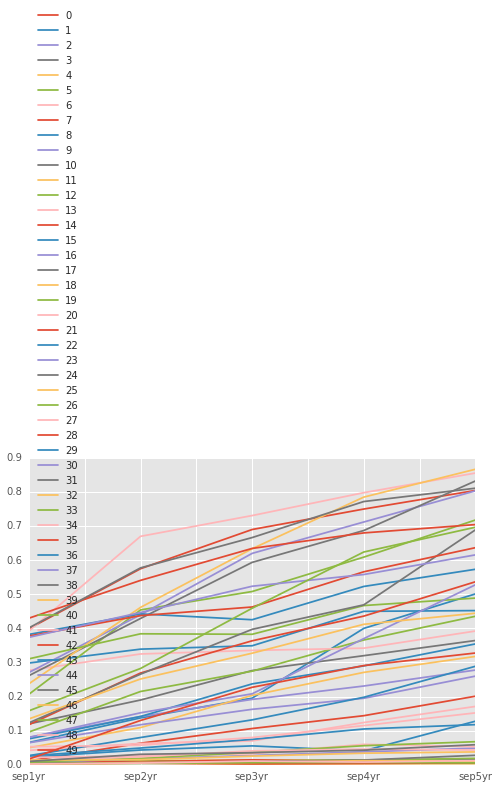

In [635]:
#sep_df.T.plot()

In [628]:
#df.rename(columns=['sep'+pyr+'yr'],inplace=True)
df.columns=['sep'+pyr+'yr']
df.head()

,sep5yr
0,0.201111
1,0.501111
2,0.277778
3,0.364444
4,0.008889


In [630]:
#sep_proba_df = sep_proba_df[1:]
pd.concat([a for a in sep_proba_df],axis=1)

,0,0,sep5yr
0,0.106364,0.144,0.201111
1,0.195455,0.400,0.501111
2,0.191818,0.231,0.277778
3,0.276364,0.320,0.364444
4,0.013636,0.014,0.008889
5,0.274545,0.366,0.435556
6,0.335455,0.342,0.392222
7,0.690000,0.750,0.804444
8,0.349091,0.450,0.452222
9,0.006364,0.007,0.014444


## Some miscellaneous, experimental visualizations of the predictions

In [586]:
print len(np.mean(eval_pred5proba[:,1,:],axis=1))
ev5df = pd.DataFrame(eval_pred5proba[:,1,:])
ev5df.head()
#ev5df['avg'] = eval_pred5proba[:,0,:].mean(axis=2)
#ev5df['avg'] = eval_pred5proba[:,0,:].min(axis=2)

,0,1,2,3,4,5,6,7,8
0,0.24,0.17,0.17,0.18,0.34,0.57,0.64,0.62,0.57
1,0.20,0.22,0.20,0.10,0.01,0.12,0.15,0.36,0.13
2,0.31,0.36,0.20,0.33,0.43,0.57,0.37,0.34,0.37
3,0.35,0.37,0.24,0.27,0.18,0.07,0.07,0.22,0.52
4,0.81,0.79,0.84,0.88,0.89,0.98,0.97,0.98,0.99


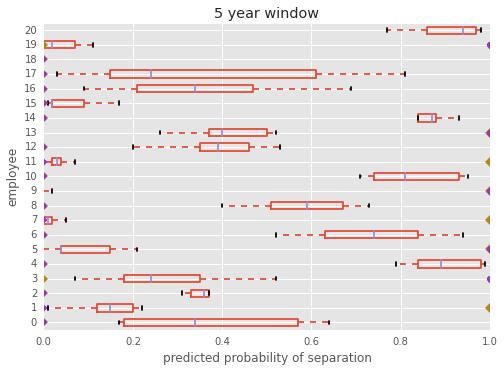

In [589]:
nshow = 21
ev5df.head(nshow).T.boxplot(vert=False)
plt.xlabel('predicted probability of separation')
plt.ylabel('employee')
plt.title('5 year window')
#plt.plot(x=y5eval[:30],y=np.arange(0,30),color='darkgoldenrod',marker='*')
for x,y in np.vstack([y5eval[:nshow],np.arange(0,nshow)]).T:
    plt.plot(x,y,'D',color='darkgoldenrod')
for x,yhat in np.vstack([map(np.int,eval_pred5class.mean(axis=1))[:nshow],np.arange(0,nshow)]).T:
    plt.plot(x,yhat,'o',color='darkorchid')

In [659]:
p_class = ev5df.head(nshow).mean(axis=1) #map(np.int,ev5df.head(nshow).mean(axis=1))


In [660]:
p_class = p_class.apply(lambda x: round(x,0))
#p_class['color']= 'red'
p_class

0     0
1     0
2     0
3     0
4     1
5     0
6     1
7     0
8     1
9     0
10    1
11    0
12    0
13    0
14    1
15    0
16    0
17    0
18    0
19    0
20    1
dtype: float64

In [657]:
cname = ['red']*21


TypeError: only integer arrays with one element can be converted to an index

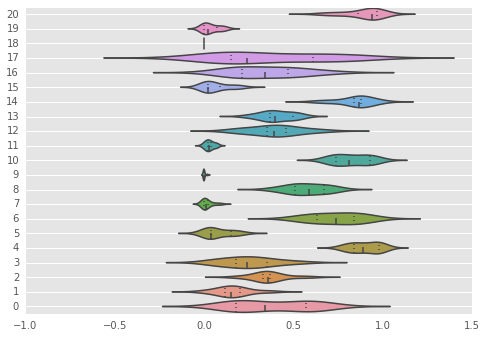

In [637]:


sns.violinplot(ev5df.head(nshow).T,vert=False)
plt.xlabel('Probability of separation')
plt.ylabel('employee')
plt.xlim([0,1])

## Create a scoring measure for different models

In [ ]:
def perform_kfold_cross_validation(model, all_X, all_y, k=5):
    """Calculate root mean squared error for each cross-validation fold.
    
    Parameters:
        model - a scikit learn model
        all_X - a pandas DataFrame with the observed input data
        all_y - a pandas Series with the observed outcome
        k - number of cross validation folds (test set will be 1/k of the data)
    
    Return value:
        An array of length 'k' with the root mean squared error
        for each fold.
    """
    # 'folds' is a generator that will yield pairs of arrays (train, test)
    # selecting row numbers for training/testing
    folds = cross_validation.KFold(n=len(all_y), n_folds=k)
    RMSE = []    # root mean squared errors
    # Loop over the cross-validation folds
    for training, testing in folds:
        # Get the training and test splits
        training = all_X.index[training]
        testing = all_X.index[testing]
        X_train, X_test = all_X.ix[training], all_X.ix[testing]
        y_train, y_test = all_y.ix[training], all_y.ix[testing]
    
        # Train the model
        model.fit(X_train, y_train)
        # Use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_fitted)))
    # Leave the model fit to the entire dataset
    model.fit(all_X, all_y)
    # And return the array of root mean squared errors
    return RMSE

### first try to generalize the temporalKfold as a class
* base this upon the KFold(_BaseKfold): class in scikitlearn
* returns an iterator

In [151]:
from sklearn.cross_validation import _BaseKFold

In [ ]:
class windowKFold(_BaseKFold):
    """windowed or temporal K-Folds cross validation iterator.
    Provides train/test indices to split data in train test sets. Split
    dataset into k consecutive folds (without shuffling).
    Each fold is then used a validation set once while the k - 1 remaining
    fold form the training set.
    Parameters
    ----------
    n : int
        Total number of elements.
    n_folds : int, default=3
        Number of folds. Must be at least 2.
    shuffle : boolean, optional
        Whether to shuffle the data before splitting into batches.
    random_state : None, int or RandomState
        Pseudo-random number generator state used for random
        sampling. If None, use default numpy RNG for shuffling
    Examples
    --------
    >>> from sklearn import cross_validation
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4])
    >>> kf = cross_validation.KFold(4, n_folds=2)
    >>> len(kf)
    2
    >>> print(kf)  # doctest: +NORMALIZE_WHITESPACE
    sklearn.cross_validation.KFold(n=4, n_folds=2, shuffle=False,
                                   random_state=None)
    >>> for train_index, test_index in kf:
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [2 3] TEST: [0 1]
    TRAIN: [0 1] TEST: [2 3]
    Notes
    -----
    The first n % n_folds folds have size n // n_folds + 1, other folds have
    size n // n_folds.
    See also
    --------
    StratifiedKFold: take label information into account to avoid building
    folds with imbalanced class distributions (for binary or multiclass
    classification tasks).
    """

    def __init__(self, n, n_folds=3, indices=None, shuffle=False,
                 random_state=None):
        super(KFold, self).__init__(n, n_folds, indices, shuffle, random_state)
        self.idxs = np.arange(n)
        if shuffle:
            rng = check_random_state(self.random_state)
            rng.shuffle(self.idxs)

    def _iter_test_indices(self):
        n = self.n
        n_folds = self.n_folds
        fold_sizes = (n // n_folds) * np.ones(n_folds, dtype=np.int)
        fold_sizes[:n % n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            yield self.idxs[start:stop]
            current = stop

    def __repr__(self):
        return '%s.%s(n=%i, n_folds=%i, shuffle=%s, random_state=%s)' % (
            self.__class__.__module__,
            self.__class__.__name__,
            self.n,
            self.n_folds,
            self.shuffle,
            self.random_state,
        )

    def __len__(self):
        return self.n_folds


In [ ]:
print("Size of the input set:", input_data.shape)

models = dict(
    logistic = linear_model.LogisticRegression(),
    gbc = ensemble.GradientBoostingClassifier(max_depth=5),
    ridge = linear_model.RidgeClassifier(),
    tree = tree.DecisionTreeClassifier(max_depth=5),
    #svc = svm.LinearSVC(),
    naive_bayes = naive_bayes.MultinomialNB(),  # Can only use if all inputs are positive
    random_forest = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5)
)

win = (spread > 0).astype(int)
rmses = {}
for name, model in models.items():
    rmses[name] = perform_kfold_cross_validation(model, input_data, win, k=3)
    
pd.DataFrame(rmses).boxplot(vert=False, return_type='axes')
plt.gcf().set_size_inches(9, 5)
plt.xlabel("Error in prediction"); plt.ylabel("Model")
plt.show()

## try building a model with deeper splits? or more trees?

In [ ]:
np.shape(X5fold)

In [ ]:
columns_for_modeling

In [ ]:
jl.dump(five_rf_mdl_100A,'frf100.pkl')

In [ ]:
%cd ../
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100'

In [ ]:
5.4 * 1000/250.

In [ ]:

five_rf_mdl = []
for i in xrange(0,len(tfold5)):
    train_y = y5fold[i].flatten()#[tfold5[i][0]]
    #train_X = #X5fold[tfold5[i][0],:,i]
    train_X = X5fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl.append(rfmdl)

In [ ]:
(evalmod['hire_tstmp']-evalmod['birth_tstmp'])/np.timedelta64(1,'Y')

In [ ]:
eval_pred_5class, eval_pred_proba5 = evaluate_models(five_rf_mdl,X5eval)

In [ ]:
eval_pred5class_100A, eval_pred5proba = evaluate_models(five_rf_mdl_100A,X5eval)

In [ ]:
len(eval_pred_5class), len(y5eval)

In [ ]:
plot_conf_matrix(y5eval,map(int,eval_pred_5class.mean(axis=1)))

In [ ]:
plot_conf_matrix(y5eval,map(int,eval_pred5class_100A.mean(axis=1)))

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
plot_conf_matrix(y5eval,map(int,eval_pred_5class.mean(axis=1)+0.3))

In [ ]:
from sklearn.externals import joblib
joblib.dump(five_rf_mdl,'five_rf_mdljl.pkl')

In [ ]:
%cd five_rf_mdljl


In [ ]:
frf= joblib.load('five_rf_mdljl.pkl')

In [ ]:
Beval_pred_5class, Beval_pred_proba5 = evaluate_models(frf,X5eval)

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,Beval_pred_proba5[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
Beval_pred5class0, Beval_pred5proba0 = evaluate_models(frf[0],X5eval)

In [ ]:
Beval_pred_proba5[:,:,0]

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,Beval_pred_proba5[:,:,4])
plt.ylim([0,1.01])

## Try again with joblib directly

In [ ]:
import joblib as jl

In [ ]:
%cd ../
!mkdir jl_5yr


In [ ]:
jldir = '/home/kesj/work/hrsepara/eda/jl_5yr/' 
os.chdir(jldir)

## repeat for 3 year

In [ ]:
tfold3,tfold3_times,panel3term,X3fold,y3fold = setup_tfold_models(em2mod,3,columns_for_modeling)
print len(tfold3)

In [ ]:
%%time
three_rf_mdl_100 = []
for i in xrange(0,len(tfold3)):
    train_y = y3fold[i].flatten()
    train_X = X3fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_estimators=100,max_features='auto',n_jobs=1)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    three_rf_mdl_100.append(rfmdl)

## dump the results

In [ ]:
%cd '../'
!mkdir 'jl_3yr_100'
%cd '/home/kesj/work/hrsepara/eda/jl_3yr_100'
three_100_list = jl.dump(three_rf_mdl_100,'trf100.pkl')

In [ ]:
len(three_100_list)

In [ ]:
X3eval, y3eval = adjust_eval_by_x_years(evalmod,3,columns_for_modeling)

In [ ]:
eval_pred3class,eval_pred3proba = evaluate_models(three_rf_mdl_100,X3eval)

In [ ]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [ ]:
#plot_conf_matrix(y3eval,eval_)
plot_conf_matrix(y3eval,map(int,eval_pred3class.mean(axis=1)))

In [ ]:
empl

In [ ]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
print columns_to_omit

## Construct a simple DataFrame of employee dates using Timestamps

In [ ]:
## Let me return to removing columns I don't want
* keep 

In [ ]:

columns_to_remove = ['']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
pipeline = Pipeline([("DF_Converter", br.DataFrameConverter(columns=X.columns)),
                     ("Cat_Converter", br.ConvertCategorical(categorical_columns=categorical_columns)),
                     ("Impute", br.ImputeData()),
                     ("clf", RandomForestClassifier(n_jobs=50))])
pipeline.fit(X, y)
pipeline.predict_proba(X_2014_validation)

## Add/replace some relevant columns to this dataframe
* POSTAL_SFI --> zip5 
* unempl_rate by joining on unemployment
* Age_hire
* terminated 
* sep_status

use a parallel dataframe for dates/timestamps

In [ ]:
class ColumnSelector(TransformerMixin):
    """ Selects column(s) from a pandas DataFrame
    """
    def __init__(self,cols):
        self.cols = cols
    def tranform(self, X, y=None):
        return X[:,self.cols]
    def fit(self, X, y=None):
        return self
    

In [ ]:
## Per discussion with HR COE team decide to truncate data after a particular date


### Helper Functions Follow
* Most taken from ```bear.py```
* 

## Note make sure you have run kinit before the following

In [ ]:
# now assign these values to the arrays
emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

In [ ]:
modeling_cols

In [ ]:
print len(modeling_cols)
sm_mod_cols = [a for a in modeling_cols]
job_function_cols = [b for b in modeling_cols if b.startswith('JOB_FUNCTION')]
job_function_cols
#for a in ['JOBCODE','grade_code','loc_descr','job_fcode','']
sm_mod_cols.remove('JOBCODE')
sm_mod_cols+=['med_surv']
print len(sm_mod_cols), len(modeling_cols)

In [ ]:
Xp = emB[sm_mod_cols].as_matrix().astype(np.float)
print np.shape(Xp)
#y_tenure = emB.Tenure_years.as_matrix().astype(np.float)
Xeval_p = emB_eval[sm_mod_cols].as_matrix().astype(np.float)


In [ ]:
%%time 
RFRforest2 = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest2.fit(Xp,y_tenure)
#importances= forest.feature_importances_
## apply to the eval subset from emB
pred_tenure_eval_2 = RFRforest2.predict(Xeval_p)
np.shape(pred_tenure_eval_2)#, np.shape(y_tenure_class.ix[eval_index])


In [ ]:
graph_feature_importances(RFRforest2,sm_mod_cols)

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
sns.regplot(emB_eval.Tenure_years, pred_tenure_eval_2,color='darkorchid')
#plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
plt.scatter(emB_eval.Tenure_years,pred_tenure_eval_2,color='darkorchid',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
plt.xlim([0,10])
plt.ylim([0,10])

## back to classifier

In [ ]:
%%time 
forest2 = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
forest2.fit(Xp,y_tenure_class.ix[train_index])
y_pred_tenure_class_2 = forest2.predict(Xeval_p)
rfc_tenureclass_conf_matrix2 = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class_2)
sns.heatmap(rfc_tenureclass_conf_matrix2, annot=True,  fmt='',cmap='Greens')#
plt.title('Random Forest Classifier Confusion Matrix')

In [ ]:
#rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
plt.title('Random Forest Classifier Confusion Matrix (before)')

In [ ]:
cm_normalized = rfc_tenureclass_conf_matrix.astype('float') / rfc_tenureclass_conf_matrix.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plt.subplot(121)
sns.heatmap(cm_normalized)#, title='Normalized confusion matrix')
plt.subplot(122)
cm_normalized2 = rfc_tenureclass_conf_matrix2.astype('float') / rfc_tenureclass_conf_matrix2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized2)